# Capstone Project 1 - Flight Delays

### Problem Statement:
- Predict whether or not the departure delay on an Origin-Destination pair, with a 6-hour prediction horizon, will exceed a 15 min threshold; such that the future delay will fall into one of two classes, ‘above threshold’ (1) and ‘below threshold’ (0).

### Background:
- 15 minutes is the threshold being utilized in the binary target class as that is what the Bureau of Transportation Statistics considers when classifying a commercial airline flight as delayed

- The dataset consists of information on all commercial U.S. domestic flights during Jan, Aug, Nov, and Dec of 2016, to then be aggregated by Origin-Destination Pairs and hour of day, creating a mock air-traffic network.

# Table of Contents
***
* [Wrangling](#Wrangling)
    1. [Initialization](#1.-Initialization)
    2. [Surface Cleaning and Pre-Processing](#2.-Surface-cleaning-and-pre-processing)
    3. [Evaluate Remaining Data](#3.-Evaluate-remaining-data)
        * [Date](#Date)
        * [Identification](#Identification)
        * [Metrics](#Metrics)
        * [Final Flights Dataframe](#Merge-content-specific-dataframes)
    4. [Create NetworkX DiGraph](#4.-Create-NetworkX-DiGraph)
    5. [Create Final Links_d Dataframe](#5.-Create-final-Links_d-dataframe)   
***
* [Storytelling](#Storytelling)
    1. [Flight Frequency](#Flight-Frequency)
        - [By Time](#Frequency-by-Time)
        - [By Carrier](#Frequency-by-Carrier)
        - [By Location](#Frequency-by-Location)
    2. [Flight Delay Distribution](#Flight-Delays)
        - [Overall](#Distribution-of-Flight-Delays)
        - [By Carrier](#Distribution-of-Delay-by-Carrier)
    3. [For Highest Traffic Airports](#Distribution-of-Delay-for-Highest-Traffic-Airports)
    - [On-Time Performance](#On-Time-Performance)
    - [Network Visualization](#Network-Visualization)
***
* [Inferential Statistics](#Inferential-Statistics)
    1. [Test for Normality and CLT in Variables of Interest](#Test-for-Normality-and-CLT-in-Variables-of-Interest)
    2. [Regression Analysis](#Regression-Analysis)
    3. [Hypothesis Tests](#Hypothesis-Tests)
        - [T-Test of Arrival and Departure Deviation Means](#Difference-of-departure-and-arrival-deviation-means)
        - [Pearson's r Permutation Test of Median Arrival and Departure Delays](#Correlation-between-median-departure-delay-and-median-arrival-delay-for-Origin-Destination-Pairs)
***
* [Model Construction](#Model-Construction)
    1. [Baseline](#Baseline-Logistic-Regression-Classifier)
        - [Initial Results](#Initial-Results:)
    2. [Final Models with Resampled Datasets](#Resampling-to-counter-dataset-imbalance)
        - [Condition 1: Under-sampling](#Condition-1:-Random-Under-sampling)
            - [Logistic Regression](#Logistic-Regression-Classifier-with-Undersampled-dataset)
            - [Random Forest](#Random-Forest-Classifier-with-Undersampled-dataset)
        - [Condition 2: Over-sampling](#Condition-2:-Synthetic-Minority-Over-sampling-Technique)
            - [Logistic Regression](#Logistic-Regression-with-Oversampled-dataset)
            - [Random Forest](#Random-Forest-Classifier-with-Oversampled-dataset)
        - [Final Results](#Final-Results:)
***

# Wrangling
***
1. [Initialization](#1.-Initialization)
  - import and view raw data
2. [Surface Cleaning and Pre-Processing](#2.-Surface-cleaning-and-pre-processing)
  - improve readability
  - address missing values
3. [Evaluate Remaining Data](#3.-Evaluate-remaining-data)
  - separate into dataframes based on component of flight information
  - address each component and reshape if necessary
      - [Date](#Date)
      - [Identification](#Identification)
      - [Metrics](#Metrics)
  - join into one final Flights dataframe
      - [Flights](#Merge-content-specific-dataframes)
4. [Create NetworkX DiGraph](#4.-Create-NetworkX-DiGraph)
  - location id and centrality metrics as node attributes
  - flight count per link, distance, and flight time as edge attributes
5. [Create Final Links_d Dataframe](#5.-Create-final-Links_d-dataframe)
  - link = unique origin to destination pair
  - utilize top 300 most traveled links as they contain high frequency of flights
  - consists of median delay times per hour per link during sample period
  - add binary target class
***
[Top](#Table-of-Contents)

### 1. Initialization

In [2]:
%matplotlib inline
import joblib
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import statsmodels.api as sm
from collections import Counter
from pandas.plotting import table
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from statsmodels.formula.api import ols
sns.set(color_codes=True)
sns.set_context("talk")

In [1]:
#create dataframe from flight data csv
flights = pd.read_csv(r"\CP1\flight_data\flight_data.csv")

#explore data
print(flights.info())
print(flights.head())
print(flights.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856061 entries, 0 to 1856060
Data columns (total 43 columns):
QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
FL_DATE                  object
UNIQUE_CARRIER           object
FL_NUM                   int64
ORIGIN_AIRPORT_ID        int64
ORIGIN_AIRPORT_SEQ_ID    int64
ORIGIN_CITY_MARKET_ID    int64
ORIGIN                   object
ORIGIN_CITY_NAME         object
ORIGIN_STATE_ABR         object
ORIGIN_STATE_NM          object
DEST_AIRPORT_ID          int64
DEST_AIRPORT_SEQ_ID      int64
DEST_CITY_MARKET_ID      int64
DEST                     object
DEST_CITY_NAME           object
DEST_STATE_ABR           object
DEST_STATE_NM            object
CRS_DEP_TIME             int64
DEP_TIME                 float64
DEP_DELAY                float64
DEP_DELAY_NEW            float64
WHEELS_ON                float64
TAXI_IN                  float64
CRS_ARR_TIME             int64

### 2. Surface cleaning and pre-processing
  - reformat headers and reindex
  - address missing values

In [2]:
#make column names lowercase
flights.columns = map(str.lower, flights.columns)

#view percentage of columns consisting of NaN
print(flights.isnull().mean())

quarter                  0.000000
month                    0.000000
day_of_month             0.000000
day_of_week              0.000000
fl_date                  0.000000
unique_carrier           0.000000
fl_num                   0.000000
origin_airport_id        0.000000
origin_airport_seq_id    0.000000
origin_city_market_id    0.000000
origin                   0.000000
origin_city_name         0.000000
origin_state_abr         0.000000
origin_state_nm          0.000000
dest_airport_id          0.000000
dest_airport_seq_id      0.000000
dest_city_market_id      0.000000
dest                     0.000000
dest_city_name           0.000000
dest_state_abr           0.000000
dest_state_nm            0.000000
crs_dep_time             0.000000
dep_time                 0.014290
dep_delay                0.014290
dep_delay_new            0.014290
wheels_on                0.015120
taxi_in                  0.015120
crs_arr_time             0.000000
arr_time                 0.015120
arr_delay     

In [3]:
#make lists of columns with high and low proportions of missing values 
high_per_nan = [col for col in flights if flights[col].isnull().mean() >= .5 ]
low_per_nan = [col for col in flights if 0 < flights[col].isnull().mean() < .5]

In [4]:
'''set aside columns containing high percentage of missing values
    - such columns contain circumstantial flight delay information for a small proportion of total flights
'''
#create dataframe containing high percentage NaN columns
hpn_cols = flights[high_per_nan]

#drop columns from flights dataframe
flights = flights.drop(columns=high_per_nan)

In [5]:
'''explore columns containing low percentage of missing values
    - create dataframe of columns with low percentage of NaN values
    - view descriptive statistics
    - view standard deviation of columns as percentage of mean to gauge variability
    - view percentage of total rows containing missing values
'''
lpn_cols = flights[low_per_nan]
print(lpn_cols.describe(include='all'))
print('coefficient of variation:','\n', lpn_cols.apply(lambda x: (x.std() / x.mean()) * 100))
print('percent of rows containing nan:', (len(flights[flights.isnull().any(axis=1)]) / len(flights)) * 100)

           dep_time     dep_delay  dep_delay_new     wheels_on       taxi_in  \
count  1.829537e+06  1.829537e+06   1.829537e+06  1.827997e+06  1.827997e+06   
mean   1.334419e+03  9.812064e+00   1.267238e+01  1.471640e+03  7.562686e+00   
std    5.004642e+02  4.166410e+01   4.064121e+01  5.270121e+02  6.047238e+00   
min    1.000000e+00 -6.000000e+01   0.000000e+00  1.000000e+00  1.000000e+00   
25%    9.200000e+02 -5.000000e+00   0.000000e+00  1.053000e+03  4.000000e+00   
50%    1.329000e+03 -2.000000e+00   0.000000e+00  1.510000e+03  6.000000e+00   
75%    1.741000e+03  7.000000e+00   7.000000e+00  1.914000e+03  9.000000e+00   
max    2.400000e+03  2.040000e+03   2.040000e+03  2.400000e+03  2.500000e+02   

           arr_time     arr_delay  arr_delay_new  crs_elapsed_time  \
count  1.827997e+06  1.824403e+06   1.824403e+06      1.856058e+06   
mean   1.476238e+03  4.206204e+00   1.259892e+01      1.463799e+02   
std    5.314493e+02  4.389959e+01   4.031154e+01      7.673182e+01   

In [6]:
'''set aside rows containing missing values from flights dataframe
    - due to high variability in critical columns (delay times) imputation of means would not be appropriate
    - rows constitute small percentage of total data
    - still possible at a later point to calculate missing values from remaining information
'''
#set aside dataframe of rows with null values
nan_rows = flights[flights.isnull().any(axis=1)]

#drop rows with null values from flights
flights = flights.drop(nan_rows.index)

#view percentage of remaining columns consisting of NaN 
print(flights.isnull().mean())

#view shape of resulting flights dataframe
print(flights.shape)

quarter                  0.0
month                    0.0
day_of_month             0.0
day_of_week              0.0
fl_date                  0.0
unique_carrier           0.0
fl_num                   0.0
origin_airport_id        0.0
origin_airport_seq_id    0.0
origin_city_market_id    0.0
origin                   0.0
origin_city_name         0.0
origin_state_abr         0.0
origin_state_nm          0.0
dest_airport_id          0.0
dest_airport_seq_id      0.0
dest_city_market_id      0.0
dest                     0.0
dest_city_name           0.0
dest_state_abr           0.0
dest_state_nm            0.0
crs_dep_time             0.0
dep_time                 0.0
dep_delay                0.0
dep_delay_new            0.0
wheels_on                0.0
taxi_in                  0.0
crs_arr_time             0.0
arr_time                 0.0
arr_delay                0.0
arr_delay_new            0.0
crs_elapsed_time         0.0
actual_elapsed_time      0.0
air_time                 0.0
flights       

### 3. Evaluate remaining data
  - separate into dataframes based on component of flight information
  - reshape if necessary
  - drop redundant columns
  - merge separate evaluated dataframes into one final Flights dataframe

In [7]:
'''separate by columns based on component of flight information
    - date
    - identifiers (carrier, origin, destination)
    - status timestamps and other metrics
'''
#create dataframes for groups of columns
date_info = flights.loc[:, 'quarter':'fl_date']
id_info = flights.loc[:, 'unique_carrier':'dest_state_nm']
flight_metrics = flights.loc[:, 'crs_dep_time':'distance']

In [8]:
'''define function for creating dictionary with unique values in columns in given dataframe
    - key as column name
    - value as array of unique values in column 
    - sort array for readability
'''
def uv_dict(dataframe):
    unique_col_values = {col: array for (col, array) in [(col, dataframe[col].unique()) for col in dataframe]}
    for col, array in unique_col_values.items():
        array = array.sort()
    return unique_col_values

### Date

In [9]:
#view unique values in flight date columns
print(uv_dict(date_info))

#view columns pertaining to flight metrics
date_info.head()

{'quarter': array([1, 3, 4], dtype=int64), 'month': array([ 1,  8, 11, 12], dtype=int64), 'day_of_month': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64), 'day_of_week': array([1, 2, 3, 4, 5, 6, 7], dtype=int64), 'fl_date': array(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
       '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
       '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
       '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
       '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
       '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
       '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
       '2016-01-29', '2016-01-30', '2016-01-31', '2016-08-01',
       '2016-08-02', '2016-08-03', '2016-08-04', '2016-08-05',
       '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09',
       '2016-08-10', '2016-08-11', '

,quarter,month,day_of_month,day_of_week,fl_date
0,1,1,3,7,2016-01-03
1,1,1,3,7,2016-01-03
2,1,1,3,7,2016-01-03
3,1,1,3,7,2016-01-03
4,1,1,3,7,2016-01-03


In [10]:
'''add columns containing day of week and month names
    -create dictionary matching numeric key to name 
    -map to each column to transform values to strings 
'''
#create dicts
dow_names = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
month_names = {1:'January', 8:'August', 11:'November', 12:'December'}

#map dict to each column
date_info['Day_of_Week'] = date_info['day_of_week'].map(dow_names)
date_info['Month'] = date_info['month'].map(month_names)

In [11]:
'''create datetime index from flight departure time and flight date
    - reformat fl_date and dep_time strings and convert to datetime
    - add dt_index as column to date info dataframe
'''
#initialize empty list
fl_datetime = []

#loop through dep_time and fl_date columns to format then append flight date
for (i, v) in zip(flights.dep_time.astype(int).apply(str), flights.fl_date):
    if len(i) == 1:
        i = '000' + i 
    elif len(i) == 2:
        i = '00' + i 
    elif len(i) == 3:
        i = '0' + i
    elif i == '2400':
        i = '0000'
    else:
        i = i[:2] + i[2:]
    fl_datetime.append(v + i)

#add datetime index as column to flights dataframe
date_info['dt_index'] = pd.to_datetime(fl_datetime, format='%Y-%m-%d%H%M')

In [12]:
#add column containing categorical value for hour of day
date_info['hour_of_day'] = date_info['dt_index'].apply(lambda x: x.strftime('%H:00'))

#view final date info dataframe
date_info.head()

,quarter,month,day_of_month,day_of_week,fl_date,Day_of_Week,Month,dt_index,hour_of_day
0,1,1,3,7,2016-01-03,Sunday,January,2016-01-03 15:24:00,15:00
1,1,1,3,7,2016-01-03,Sunday,January,2016-01-03 07:44:00,07:00
2,1,1,3,7,2016-01-03,Sunday,January,2016-01-03 18:58:00,18:00
3,1,1,3,7,2016-01-03,Sunday,January,2016-01-03 20:54:00,20:00
4,1,1,3,7,2016-01-03,Sunday,January,2016-01-03 12:52:00,12:00


### Identification

****
#### Bureau of Transportation Statistics Definitions
(https://www.transtats.bts.gov/Fields.asp?Table_ID=292)
****

In [13]:
#create dictionary of unique values in id columns
id_uv = uv_dict(id_info)
print(id_uv)

#view columns pertaining to flight id
id_info.head()

{'unique_carrier': array(['AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'NK', 'OO', 'UA', 'VX',
       'WN'], dtype=object), 'fl_num': array([   1,    2,    3, ..., 7437, 7438, 7439], dtype=int64), 'origin_airport_id': array([10135, 10136, 10140, 10141, 10146, 10154, 10155, 10157, 10158,
       10165, 10170, 10185, 10208, 10245, 10257, 10279, 10299, 10333,
       10372, 10397, 10408, 10423, 10431, 10434, 10469, 10529, 10551,
       10561, 10577, 10581, 10599, 10620, 10627, 10631, 10666, 10685,
       10693, 10713, 10721, 10728, 10731, 10732, 10739, 10747, 10754,
       10779, 10781, 10785, 10792, 10800, 10821, 10849, 10868, 10874,
       10918, 10926, 10980, 10990, 10994, 11003, 11013, 11042, 11049,
       11057, 11066, 11076, 11097, 11109, 11122, 11140, 11146, 11150,
       11193, 11203, 11252, 11259, 11267, 11278, 11292, 11298, 11308,
       11336, 11337, 11413, 11423, 11433, 11447, 11471, 11481, 11495,
       11503, 11525, 11537, 11540, 11577, 11587, 11603, 11612, 11617,
       11618, 1

,unique_carrier,fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,origin_state_abr,origin_state_nm,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest,dest_city_name,dest_state_abr,dest_state_nm
0,F9,694,11292,1129202,30325,DEN,"Denver, CO",CO,Colorado,11003,1100303,31003,CID,"Cedar Rapids/Iowa City, IA",IA,Iowa
1,F9,809,14027,1402702,34027,PBI,"West Palm Beach/Palm Beach, FL",FL,Florida,11292,1129202,30325,DEN,"Denver, CO",CO,Colorado
2,F9,907,15356,1535602,35356,TTN,"Trenton, NJ",NJ,New Jersey,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,North Carolina
3,F9,908,14492,1449202,34492,RDU,"Raleigh/Durham, NC",NC,North Carolina,15356,1535602,35356,TTN,"Trenton, NJ",NJ,New Jersey
4,F9,915,15356,1535602,35356,TTN,"Trenton, NJ",NJ,New Jersey,13930,1393004,30977,ORD,"Chicago, IL",IL,Illinois


In [14]:
"""remove state abbreviation suffix from city_name values
    - already present in state_abr columns
    - create function to remove abbreviations from list of columns in a dataframe
"""
def remove_abbr(dataframe, lst_of_columns):
    for col in lst_of_columns:
        dataframe[col] = dataframe[col].str[:-4]

#call function on id info for origin and destination city name columns 
remove_abbr(id_info,['origin_city_name','dest_city_name'])

In [15]:
#drop origin_airport_seq_id and dest_airport_seq_id
id_info.drop(['origin_airport_seq_id','dest_airport_seq_id'], 1, inplace=True)

In [16]:
'''create link column from origin and destination name columns
    - link = unique origin to destination pair
'''
id_info['link'] = id_info['origin'] + '-' + id_info['dest']

In [17]:
'''add unique carrier name column
    - create dict of unique_carrier codes to names
    - map to unique_carrier column to transform values to strings
    - carrier names were acquired from BTS statistics definitions
'''
unique_carrier_dict = {'F9':'Frontier Airlines Inc.','HA':'Hawaiian Airlines Inc.','DL':'Delta Air Lines Inc.',
                       'NK':'Spirit Air Lines','EV':'ExpressJet Airlines Inc.','OO':'SkyWest Airlines Inc.',
                       'UA':'United Air Lines Inc.','VX':'Virgin America','AA':'American Airlines Inc.',
                       'AS':'Alaska Airlines Inc.','B6':'JetBlue Airways','WN':'Southwest Airlines Co.'}

#map dict to unique_carrier column
id_info['unique_carrier_nm'] = id_info['unique_carrier'].map(unique_carrier_dict)

#view final dataframe on flight origin and destination
id_info.head()

,unique_carrier,fl_num,origin_airport_id,origin_city_market_id,origin,origin_city_name,origin_state_abr,origin_state_nm,dest_airport_id,dest_city_market_id,dest,dest_city_name,dest_state_abr,dest_state_nm,link,unique_carrier_nm
0,F9,694,11292,30325,DEN,Denver,CO,Colorado,11003,31003,CID,Cedar Rapids/Iowa City,IA,Iowa,DEN-CID,Frontier Airlines Inc.
1,F9,809,14027,34027,PBI,West Palm Beach/Palm Beach,FL,Florida,11292,30325,DEN,Denver,CO,Colorado,PBI-DEN,Frontier Airlines Inc.
2,F9,907,15356,35356,TTN,Trenton,NJ,New Jersey,14492,34492,RDU,Raleigh/Durham,NC,North Carolina,TTN-RDU,Frontier Airlines Inc.
3,F9,908,14492,34492,RDU,Raleigh/Durham,NC,North Carolina,15356,35356,TTN,Trenton,NJ,New Jersey,RDU-TTN,Frontier Airlines Inc.
4,F9,915,15356,35356,TTN,Trenton,NJ,New Jersey,13930,30977,ORD,Chicago,IL,Illinois,TTN-ORD,Frontier Airlines Inc.


### Metrics

****
#### Bureau of Transportation Statistics Definitions
(https://www.transtats.bts.gov/Fields.asp)
****

In [18]:
#view unique values in flight metrics columns
print(uv_dict(flight_metrics))

#view columns pertaining to flight metrics
flight_metrics.head()

{'crs_dep_time': array([   1,    2,    3, ..., 2357, 2358, 2359], dtype=int64), 'dep_time': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.358e+03, 2.359e+03,
       2.400e+03]), 'dep_delay': array([ -60.,  -58.,  -54., ..., 1663., 1964., 2040.]), 'dep_delay_new': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.663e+03, 1.964e+03,
       2.040e+03]), 'wheels_on': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 2.358e+03, 2.359e+03,
       2.400e+03]), 'taxi_in': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  

,crs_dep_time,dep_time,dep_delay,dep_delay_new,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,arr_delay_new,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance
0,1525,1524.0,-1.0,0.0,1807.0,8.0,1820,1815.0,-5.0,0.0,115.0,111.0,87.0,1.0,692.0
1,700,744.0,44.0,44.0,940.0,8.0,929,948.0,19.0,19.0,269.0,244.0,224.0,1.0,1679.0
2,1845,1858.0,13.0,13.0,2006.0,7.0,2015,2013.0,-2.0,0.0,90.0,75.0,60.0,1.0,373.0
3,2055,2054.0,-1.0,0.0,2208.0,7.0,2220,2215.0,-5.0,0.0,85.0,81.0,57.0,1.0,373.0
4,1250,1252.0,2.0,2.0,1349.0,51.0,1420,1440.0,20.0,20.0,150.0,168.0,107.0,1.0,693.0


In [19]:
'''remove flights column from metrics dataframe
    - all rows contain only one flight i.e. column values are redundant
'''
flight_metrics = flight_metrics.drop(columns='flights')

In [20]:
'''rename delay columns for clarity
    - dep_delay and arr_delay to dep_deviation and arr_deviation
      values can also indicate instances of early flights
    - dep_delay_new and arr_delay_new to dep_delay and arr_delay
      they are exclusively indicative of flight delay   
'''
flight_metrics.rename(columns={'dep_delay':'dep_deviation', 'dep_delay_new':'dep_delay',
                               'arr_delay':'arr_deviation','arr_delay_new':'arr_delay'}, inplace=True)

#view resulting flight metrics dataframe
flight_metrics.head()

,crs_dep_time,dep_time,dep_deviation,dep_delay,wheels_on,taxi_in,crs_arr_time,arr_time,arr_deviation,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance
0,1525,1524.0,-1.0,0.0,1807.0,8.0,1820,1815.0,-5.0,0.0,115.0,111.0,87.0,692.0
1,700,744.0,44.0,44.0,940.0,8.0,929,948.0,19.0,19.0,269.0,244.0,224.0,1679.0
2,1845,1858.0,13.0,13.0,2006.0,7.0,2015,2013.0,-2.0,0.0,90.0,75.0,60.0,373.0
3,2055,2054.0,-1.0,0.0,2208.0,7.0,2220,2215.0,-5.0,0.0,85.0,81.0,57.0,373.0
4,1250,1252.0,2.0,2.0,1349.0,51.0,1420,1440.0,20.0,20.0,150.0,168.0,107.0,693.0


### Merge content-specific dataframes

In [21]:
'''create final flights dataframe
    - join edited content-specific dataframes
    - create multiindex from link and flight departure datetime index, dt_index
'''
flights = date_info.join(id_info).join(flight_metrics).sort_values(by=['link','fl_date','dep_time'])

#create multiIndexed dataframe from link and dt_index columns
flights = flights.set_index(['link', 'dt_index'],drop=False).sort_index()

#view final flights dataframe
print(flights.info())
flights.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1824403 entries, (ABE-ATL, 2016-01-01 07:00:00) to (YUM-PHX, 2016-12-31 19:15:00)
Data columns (total 39 columns):
quarter                  int64
month                    int64
day_of_month             int64
day_of_week              int64
fl_date                  object
Day_of_Week              object
Month                    object
dt_index                 datetime64[ns]
hour_of_day              object
unique_carrier           object
fl_num                   int64
origin_airport_id        int64
origin_city_market_id    int64
origin                   object
origin_city_name         object
origin_state_abr         object
origin_state_nm          object
dest_airport_id          int64
dest_city_market_id      int64
dest                     object
dest_city_name           object
dest_state_abr           object
dest_state_nm            object
link                     object
unique_carrier_nm        object
crs_dep_time             int64
dep_t

quarter  month  day_of_month  day_of_week  \
link    dt_index                                                         
ABE-ATL 2016-01-01 07:00:00        1      1             1            5   
        2016-01-01 16:09:00        1      1             1            5   
        2016-01-02 06:00:00        1      1             2            6   
        2016-01-02 16:12:00        1      1             2            6   
        2016-01-03 05:57:00        1      1             3            7   

                                fl_date Day_of_Week    Month  \
link    dt_index                                               
ABE-ATL 2016-01-01 07:00:00  2016-01-01      Friday  January   
        2016-01-01 16:09:00  2016-01-01      Friday  January   
        2016-01-02 06:00:00  2016-01-02    Saturday  January   
        2016-01-02 16:12:00  2016-01-02    Saturday  January   
        2016-01-03 05:57:00  2016-01-03      Sunday  January   

                                       dt_index hour_of_day unique_carrier  \
link    dt_index                                                             
ABE-ATL 2016-01-01 07:00:00 2016-01-01 07:00:00       07:00             EV   
        2016-01-01 16:09:00 2016-01-01 16:09:00       16:00             EV   
        2016-01-02 06:00:00 2016-01-02 06:00:00       06:00             EV   
        2016-01-02 16:12:00 2016-01-02 16:12:00       16:00             EV   
        2016-01-03 05:57:00 2016-01-03 05:57:00       05:00             EV   

                              ...     wheels_on  taxi_in  crs_arr_time  \
link    dt_index              ...                                        
ABE-ATL 2016-01-01 07:00:00   ...         900.0      7.0           845   
        2016-01-01 16:09:00   ...        1812.0      5.0          1828   
        2016-01-02 06:00:00   ...         753.0      6.0           812   
        2016-01-02 16:12:00   ...        1800.0      7.0          1827   
        2016-01-03 05:57:00   ...         753.0      5.0           813   

                            arr_time arr_deviation arr_delay crs_elapsed_time  \
link    dt_index                                                                
ABE-ATL 2016-01-01 07:00:00    907.0          22.0      22.0            135.0   
        2016-01-01 16:09:00   1817.0         -11.0       0.0            138.0   
        2016-01-02 06:00:00    759.0         -13.0       0.0            132.0   
        2016-01-02 16:12:00   1807.0         -20.0       0.0            137.0   
        2016-01-03 05:57:00    758.0         -15.0       0.0            133.0   

                             actual_elapsed_time  air_time distance  
link    dt_index                                                     
ABE-ATL 2016-01-01 07:00:00                127.0     111.0    692.0  
        2016-01-01 16:09:00                128.0     115.0    692.0  
        2016-01-02 06:00:00                119.0     101.0    692.0  
        2016-01-02 16:12:00                115.0      98.0    692.0  
        2016-01-03 05:57:00                121.0     107.0    692.0  

[5 rows x 39 columns]

### 4. Create NetworkX DiGraph
- location id and centrality metrics as node attributes
- flight count per link, distance, and flight time as edge attributes

In [22]:
#group flights dataframe by link and slice for columns pertaining to location information
link_summary = flights.set_index(['link']).groupby(level='link').mean()[['distance','crs_elapsed_time']]

#iterate over location_summary and list of location name columns to add label strings
nm_lst = ['origin','origin_city_name','origin_state_nm','dest','dest_city_name','dest_state_nm']
for i in link_summary.index:
    for nm in nm_lst:
        link_summary.loc[i, nm] = flights.loc[i, nm][0]

#add number of flights per link as weights in link_summary dataframe
for i, v in flights.link.value_counts().iteritems():
    link_summary.loc[i, 'weight'] = int(v) 
    
#round crs_elapsed_time and sort location summary by origin state name to improve readability
link_summary = link_summary.round({'crs_elapsed_time': 0}).sort_values(by='origin_state_nm')

#create networkx graph 
G = nx.from_pandas_edgelist(link_summary, 'origin', 'dest', ['weight','distance','crs_elapsed_time'],
                            create_using=nx.DiGraph())

In [23]:
#create series of Degree distribution i.e. neighbors per node
deg_dist = pd.Series(data=[len([nbr for nbr in G.neighbors(n)]) for n in G.nodes()],
                        index=[n for n in G.nodes()]).sort_values(ascending=False)

#create series of Degree centrality i.e. # of neighbors/all neigbors possible per node
deg_cent = pd.Series(nx.degree_centrality(G)).sort_values(ascending=False)

#create series of Betweenness centrality i.e. # of shortest paths through node/ all short paths
bet_cent = pd.Series(nx.betweenness_centrality(G)).sort_values(ascending=False)

#create dataframe of node attributes
node_attr_df = pd.DataFrame(data={'Degree':deg_dist,'Degree Centrality':deg_cent,
                                  'Betweenness Centrality':bet_cent}, index=list(G.nodes()),
                            columns=['Degree','Degree Centrality',
                                     'Betweenness Centrality']).sort_values('Degree Centrality', ascending=False)

#create dict of node attributes
node_attr_dict = node_attr_df.to_dict(orient='index')

'''create dict of node location name attributes from link summary 
   - rename origin to node for clarity
'''
origin_city_state = link_summary[['origin','origin_city_name','origin_state_nm']].drop_duplicates()
origin_city_state.columns = ['node', 'city_name','state_name']
name_attr_dict = origin_city_state.set_index('node').to_dict(orient='index')

#add attributes to nodes
nx.set_node_attributes(G, node_attr_dict)
nx.set_node_attributes(G, name_attr_dict)

### 5. Create final Links_d dataframe
  - link = unique origin to destination pair
  - utilize top 300 most traveled links as they contain high frequency of flights
  - create links dataframe consisting of median delay times per hour per link during sample period
  - add binary target class

In [24]:
#create series of link counts
link_counts = flights['link'].value_counts()

#create top links dataframe from list of top 300 pairs
top_links = flights[flights.link.isin(link_counts[:300].index.tolist())]

In [25]:
'''create list of dataframes resampled by link and hour
    - maintains link-specific temporal information
    - loop through multiIndex for top 100 links
    - resample link-specific dataframes by hour and append to empty list
'''
links_hourly_lst = []
for n in top_links.index.get_level_values(0).unique():
    n_df = top_links.loc[n]
    n_hourly = n_df.resample('60T').median().fillna(method='pad')
    n_hourly['link'] = n
    links_hourly_lst.append(n_hourly)

#concatenate resampled dataframes in list
links_hourly_concat = pd.concat(links_hourly_lst)

In [26]:
'''create links dataframe 
    - slice for months in original sample
    - avoids having final links dataframe consist of mostly filled values
    - object columns not yet dummified
'''
#create list of months in original sample
sample_months = top_links.index.get_level_values(1).month.unique().tolist()

#populate empty list with slices of the concatenated links_hourly dataframe containing sample months
links_s_months_lst= []
for month in sample_months:
    links_nmonth = links_hourly_concat.loc[links_hourly_concat.index.month == month]
    links_s_months_lst.append(links_nmonth)

#concatenate list of sample month slices 
links = pd.concat(links_s_months_lst)

#add datetime index as a column
links['dt_index'] = links.index

#add links column to the create multiIndex
links = links.set_index(['link','dt_index'],drop=False)

In [27]:
#define function to change id columns to names
def all_ids_to_names(df_w_names, df_w_ids, dict_of_cols):
    
    #define function for creating a dictionary of id-key: name-values, then adding names column in desired dataframe
    def name_for_id(df_w_name, df_w_id, name_col, id_col):
        nm_id_series = df_w_name[[name_col, id_col]].drop_duplicates().set_index(id_col)  
        nm_id_dict = {c_id: nm for (c_id, nm) in zip(nm_id_series.index.values, nm_id_series[name_col])}
        df_w_id[name_col] = df_w_id[id_col].replace(nm_id_dict)
        
    #loop through dictionary of all id and name columns and add names to dataframe containing only ids 
    for i, n in dict_of_cols.items():
        name_for_id(df_w_names, df_w_ids, n, i)
        
#create dictionary of id-name columns
id_name_dict = {'origin_airport_id':'origin', 'dest_airport_id':'dest',
                'origin_city_market_id':'origin_city_name', 'dest_city_market_id':'dest_city_name'}

#add airport and city names to links dataframe
all_ids_to_names(flights, links, id_name_dict)

In [28]:
'''drop redundant columns
    - fl_num column since flights have been aggregated
    - id columns since names have been added
    - dt_index column as MulitiIndex has already been created
'''
links = links.drop(['fl_num','origin_airport_id','origin_city_market_id',
                    'dest_airport_id','dest_city_market_id','dt_index'], axis=1)

#view final links dataframe
print(links.info())
links.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 882815 entries, (ANC-SEA, 2016-01-01 00:00:00) to (TPA-ATL, 2016-12-31 19:00:00)
Data columns (total 23 columns):
quarter                882815 non-null float64
month                  882815 non-null float64
day_of_month           882815 non-null float64
day_of_week            882815 non-null float64
crs_dep_time           882815 non-null float64
dep_time               882815 non-null float64
dep_deviation          882815 non-null float64
dep_delay              882815 non-null float64
wheels_on              882815 non-null float64
taxi_in                882815 non-null float64
crs_arr_time           882815 non-null float64
arr_time               882815 non-null float64
arr_deviation          882815 non-null float64
arr_delay              882815 non-null float64
crs_elapsed_time       882815 non-null float64
actual_elapsed_time    882815 non-null float64
air_time               882815 non-null float64
distance               882815 non-nul

quarter  month  day_of_month  day_of_week  \
link    dt_index                                                         
ANC-SEA 2016-01-01 00:00:00      1.0    1.0           1.0          5.0   
        2016-01-01 01:00:00      1.0    1.0           1.0          5.0   
        2016-01-01 02:00:00      1.0    1.0           1.0          5.0   
        2016-01-01 03:00:00      1.0    1.0           1.0          5.0   
        2016-01-01 04:00:00      1.0    1.0           1.0          5.0   

                             crs_dep_time  dep_time  dep_deviation  dep_delay  \
link    dt_index                                                                
ANC-SEA 2016-01-01 00:00:00          45.0      38.5           -6.5        0.0   
        2016-01-01 01:00:00          45.0      38.5           -6.5        0.0   
        2016-01-01 02:00:00         250.0     249.0           -1.0        0.0   
        2016-01-01 03:00:00         250.0     249.0           -1.0        0.0   
        2016-01-01 04:00:00         500.0     455.0           -5.0        0.0   

                             wheels_on  taxi_in      ...        arr_delay  \
link    dt_index                                     ...                    
ANC-SEA 2016-01-01 00:00:00      491.0      4.0      ...              8.0   
        2016-01-01 01:00:00      491.0      4.0      ...              8.0   
        2016-01-01 02:00:00      720.0      7.0      ...             17.0   
        2016-01-01 03:00:00      720.0      7.0      ...             17.0   
        2016-01-01 04:00:00      926.0      5.0      ...              1.0   

                             crs_elapsed_time  actual_elapsed_time  air_time  \
link    dt_index                                                               
ANC-SEA 2016-01-01 00:00:00             207.5                216.5     190.5   
        2016-01-01 01:00:00             207.5                216.5     190.5   
        2016-01-01 02:00:00             200.0                218.0     194.0   
        2016-01-01 03:00:00             200.0                218.0     194.0   
        2016-01-01 04:00:00             210.0                216.0     193.0   

                             distance     link  origin  dest origin_city_name  \
link    dt_index                                                                
ANC-SEA 2016-01-01 00:00:00    1448.0  ANC-SEA     ANC   SEA        Anchorage   
        2016-01-01 01:00:00    1448.0  ANC-SEA     ANC   SEA        Anchorage   
        2016-01-01 02:00:00    1448.0  ANC-SEA     ANC   SEA        Anchorage   
        2016-01-01 03:00:00    1448.0  ANC-SEA     ANC   SEA        Anchorage   
        2016-01-01 04:00:00    1448.0  ANC-SEA     ANC   SEA        Anchorage   

                            dest_city_name  
link    dt_index                            
ANC-SEA 2016-01-01 00:00:00        Seattle  
        2016-01-01 01:00:00        Seattle  
        2016-01-01 02:00:00        Seattle  
        2016-01-01 03:00:00        Seattle  
        2016-01-01 04:00:00        Seattle  

[5 rows x 23 columns]

In [29]:
'''create final links_d dataframe 
    - dummify link, quarter, month, day_of_week, day_of_month columns
'''
links_d = pd.get_dummies(links, columns=['link','quarter','month','day_of_week','day_of_month',
                                         'origin','origin_city_name','dest','dest_city_name'])

### Define target variables

In [30]:
'''write function to create series consisting of delay values at a future time
    - loop through each link since time-frames vary per sample i.e. not every link had traffic all 24 hours
    - shift series of delay values by -N amount to get values N hours away from the datetime in each row
    - forward fill missing values to maintain delay propagation dynamic
'''
def in_nhours(df, col, n_hours, grouping_level):
    future_lst = []
    for i in df.index.get_level_values(grouping_level).unique().sort_values():
        future_lst.append(df.loc[i, col].shift(-n_hours).fillna(method='ffill'))
    future_values_array = pd.concat(future_lst).values
    return future_values_array

In [31]:
#add column of departure delay values 6 hours past the current datetime to links_d dataframe
links_d = links_d.assign(dd_in_6hrs = in_nhours(links_d, 'dep_delay', 6, 'link'))

In [32]:
'''add target column to links_d dataframe
    - derived from departure delay in 6hrs in this case
    - 1 if delayed (15min past scheduled time per Bureau of Transportation statistics)
    - 0 otherwise
'''
links_d['dd_binary'] = (links_d['dd_in_6hrs'] >= 15)*1

In [33]:
#separate list of feature names from target columns
features = links_d.columns[:-3]

In [34]:
#view final links_d dataframe
print(links_d.info())
print(links_d.columns)
links_d.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 882815 entries, (ANC-SEA, 2016-01-01 00:00:00) to (TPA-ATL, 2016-12-31 19:00:00)
Columns: 561 entries, crs_dep_time to dd_binary
dtypes: float64(15), int32(1), uint8(545)
memory usage: 566.6+ MB
None
Index(['crs_dep_time', 'dep_time', 'dep_deviation', 'dep_delay', 'wheels_on',
       'taxi_in', 'crs_arr_time', 'arr_time', 'arr_deviation', 'arr_delay',
       ...
       'dest_city_name_San Diego', 'dest_city_name_San Jose',
       'dest_city_name_San Juan', 'dest_city_name_Seattle',
       'dest_city_name_St. Louis', 'dest_city_name_Tampa',
       'dest_city_name_Washington',
       'dest_city_name_West Palm Beach/Palm Beach', 'dd_in_6hrs', 'dd_binary'],
      dtype='object', length=561)


crs_dep_time  dep_time  dep_deviation  dep_delay  \
link    dt_index                                                                
ANC-SEA 2016-01-01 00:00:00          45.0      38.5           -6.5        0.0   
        2016-01-01 01:00:00          45.0      38.5           -6.5        0.0   
        2016-01-01 02:00:00         250.0     249.0           -1.0        0.0   
        2016-01-01 03:00:00         250.0     249.0           -1.0        0.0   
        2016-01-01 04:00:00         500.0     455.0           -5.0        0.0   

                             wheels_on  taxi_in  crs_arr_time  arr_time  \
link    dt_index                                                          
ANC-SEA 2016-01-01 00:00:00      491.0      4.0         512.5     515.0   
        2016-01-01 01:00:00      491.0      4.0         512.5     515.0   
        2016-01-01 02:00:00      720.0      7.0         710.0     727.0   
        2016-01-01 03:00:00      720.0      7.0         710.0     727.0   
        2016-01-01 04:00:00      926.0      5.0         930.0     931.0   

                             arr_deviation  arr_delay    ...      \
link    dt_index                                         ...       
ANC-SEA 2016-01-01 00:00:00            2.5        8.0    ...       
        2016-01-01 01:00:00            2.5        8.0    ...       
        2016-01-01 02:00:00           17.0       17.0    ...       
        2016-01-01 03:00:00           17.0       17.0    ...       
        2016-01-01 04:00:00            1.0        1.0    ...       

                             dest_city_name_San Diego  \
link    dt_index                                        
ANC-SEA 2016-01-01 00:00:00                         0   
        2016-01-01 01:00:00                         0   
        2016-01-01 02:00:00                         0   
        2016-01-01 03:00:00                         0   
        2016-01-01 04:00:00                         0   

                             dest_city_name_San Jose  dest_city_name_San Juan  \
link    dt_index                                                                
ANC-SEA 2016-01-01 00:00:00                        0                        0   
        2016-01-01 01:00:00                        0                        0   
        2016-01-01 02:00:00                        0                        0   
        2016-01-01 03:00:00                        0                        0   
        2016-01-01 04:00:00                        0                        0   

                             dest_city_name_Seattle  dest_city_name_St. Louis  \
link    dt_index                                                                
ANC-SEA 2016-01-01 00:00:00                       1                         0   
        2016-01-01 01:00:00                       1                         0   
        2016-01-01 02:00:00                       1                         0   
        2016-01-01 03:00:00                       1                         0   
        2016-01-01 04:00:00                       1                         0   

                             dest_city_name_Tampa  dest_city_name_Washington  \
link    dt_index                                                               
ANC-SEA 2016-01-01 00:00:00                     0                          0   
        2016-01-01 01:00:00                     0                          0   
        2016-01-01 02:00:00                     0                          0   
        2016-01-01 03:00:00                     0                          0   
        2016-01-01 04:00:00                     0                          0   

                             dest_city_name_West Palm Beach/Palm Beach  \
link    dt_index                                                         
ANC-SEA 2016-01-01 00:00:00                                          0   
        2016-01-01 01:00:00                                          0   
        2016-01-01 02:00:00                                      

# Storytelling
***
1. [Flight Frequency](#Flight-Frequency)
    - [By Time](#Frequency-by-Time)
    - [By Carrier](#Frequency-by-Carrier)
    - [By Location](#Frequency-by-Location)
- [Flight Delay Distribution](#Flight-Delays)
    - [Overall](#Distribution-of-Flight-Delays)
    - [By Carrier](#Distribution-of-Delay-by-Carrier)
    - [For Highest Traffic Airports](#Distribution-of-Delay-for-Highest-Traffic-Airports)
- [On-Time Performance](#On-Time-Performance)
- [Network Visualization](#Network-Visualization)
***
[Top](#Table-of-Contents)

### Flight Frequency

###### Frequency by Time 

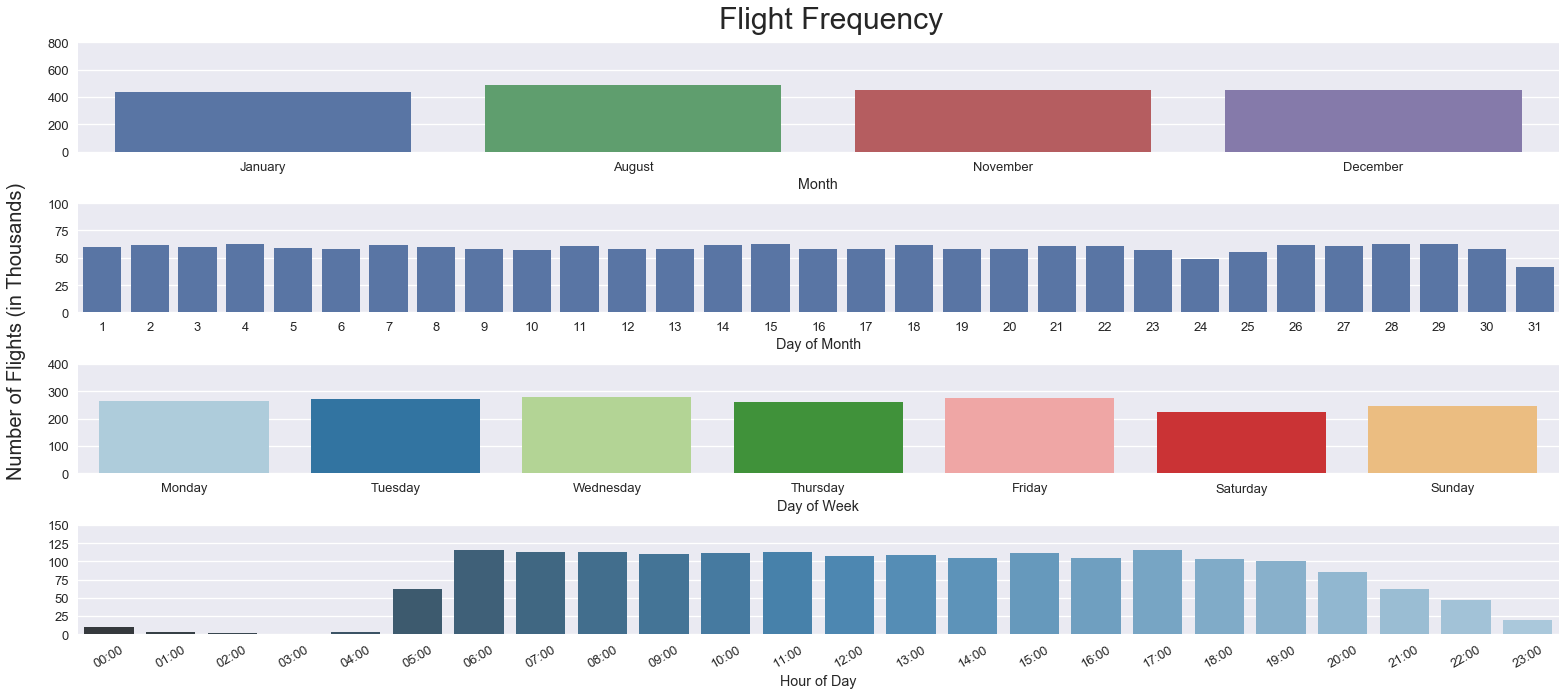

In [192]:
#create countplots of flights organized by temporal identifiers
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(22,10))
sns.countplot("Month", data=flights, ax=ax0)
sns.countplot("day_of_month", data=flights, ax=ax1, color='b')
sns.countplot("Day_of_Week", data=flights, ax=ax2, palette='Paired',
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
sns.countplot("hour_of_day", data=flights, ax=ax3, palette='Blues_d',
              order=['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00',
                    '09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00',
                    '18:00','19:00','20:00','21:00','22:00','23:00'])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.text(0.01, 0.5, 'Number of Flights (in Thousands)', va='center', rotation='vertical', fontsize=20)
ax0.set(xlabel="Month", ylabel='', ylim=(0,800000), yticks=np.arange(0,800001,200000),
        yticklabels=['0','200','400','600','800'])
ax1.set(xlabel="Day of Month", ylabel='', ylim=(0,100000), yticks=np.arange(0,100001,25000),
        yticklabels=['0','25','50','75','100'])
ax2.set(xlabel="Day of Week", ylabel='', ylim=(0,400000), yticks=np.arange(0,500001,100000),
        yticklabels=['0','100','200','300','400'])
ax3.set(xlabel="Hour of Day",ylabel='', ylim=(0,150000), yticks=np.arange(0,150001,25000),
        yticklabels=['0','25','50','75','100','125','150'])
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30)
title = plt.suptitle('Flight Frequency', fontsize=30)
title.set_x(0.53)
title.set_y(0.95)
plt.savefig('Freq_by_time.png')

##### Frequency by Carrier
<div class="span5 alert alert-success">
<p>Data consists of the 12 major domestic passenger airlines.
The United States Department of Transportation defines a major carrier or major airline carrier as a U.S.-based airline that posts more than $1 billion in revenue during a fiscal year, grouped accordingly as "Group III" ("Air Carrier Groupings 2016", U.S. Bureau of Transportation)</p>
</div>

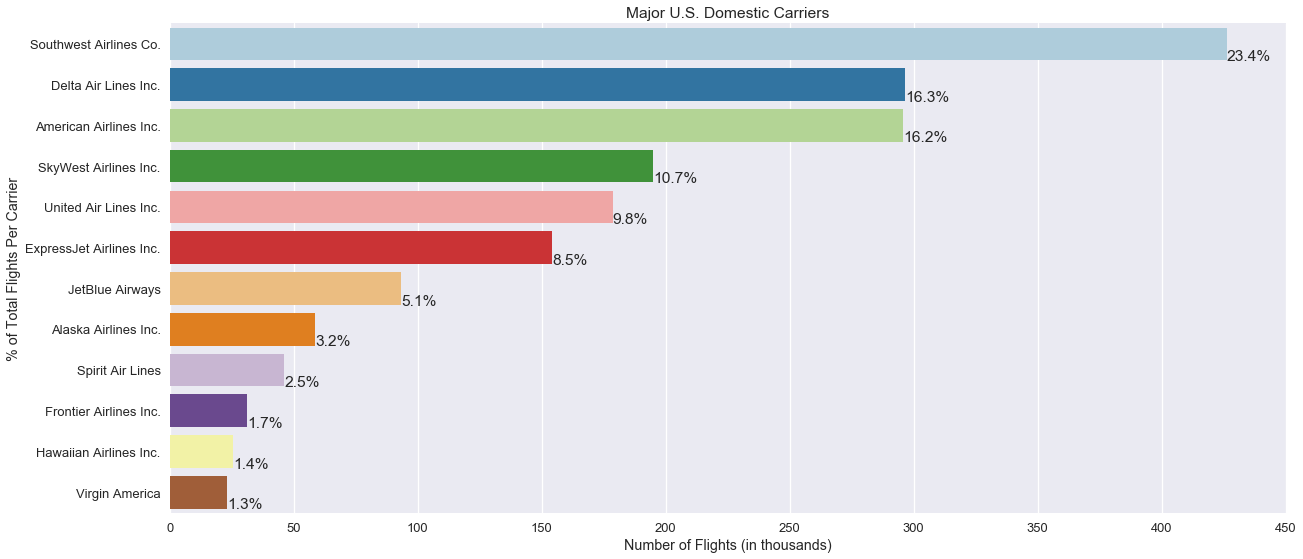

In [179]:
# plot number of flights frequency per carrier
fig, ax = plt.subplots(figsize=(20,9))
sns.countplot(y="unique_carrier_nm", data=flights, palette="Paired",ax=ax,
             order=flights.unique_carrier_nm.value_counts().index.tolist())
ax.set(title="Major U.S. Domestic Carriers", xlabel='Number of Flights (in thousands)', xticks=np.arange(0,450001,50000),
       ylabel='% of Total Flights Per Carrier', xticklabels=[str(i) for i in np.arange(0,451,50)])
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100.*p.get_width()/len(flights)), 
                (p.get_width()+0.5, p.get_bbox().get_points()[1,1]))
plt.savefig('Total_flights_by_carrier.png')

##### Frequency by Location

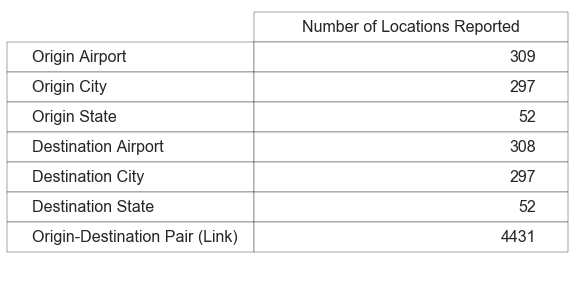

In [164]:
#create dataframe of location identifier columns with unique value counts
location_cols = ['origin', 'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm', 'link']
unique_loc_counts = pd.DataFrame({'Location Identifier':['Origin Airport', 'Origin City', 'Origin State',
                                                     'Destination Airport', 'Destination City',
                                                     'Destination State','Origin-Destination Pair (Link)'],
                              'Number of Locations Reported':[len(flights[i].unique()) for i in location_cols]}).set_index('Location Identifier')

#show dataframe of unique location counts
fig, ax = plt.subplots(figsize=(9, 5))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
tb = table(ax, unique_loc_counts, loc='upper right', colWidths=[0.25]*len(unique_loc_counts.columns))
tb.auto_set_font_size(False) 
tb.set_fontsize(16) 
tb.scale(2.5, 2.5) 
plt.savefig('Freq_by_location_id.png')

In [6]:
#define function for getting list and dataframe slice of top n values in column
def top_nvals(series, data, size):
    ntop_counts = series.value_counts()
    ntop_lst = ntop_counts.nlargest(size).index.tolist()
    ntop_df = data.loc[series.isin(ntop_counts[:size].index.tolist())]
    return ntop_lst, ntop_df

In [7]:
'''unpack lists and dataframes of top values per location identifier 
'''
#top 10 origin airports
top10_OA, topOA_df = top_nvals(flights.origin, flights, 10)

#top 10 origin cities
top10_OC, topOC_df = top_nvals(flights.origin_city_name, flights, 10)

#top 10 origin states
top10_OS, topOS_df = top_nvals(flights.origin_state_nm, flights, 10)

#top 10 destination airports
top10_DA, topDA_df = top_nvals(flights.dest, flights, 10)

#top 10 destination cities
top10_DC, topDC_df = top_nvals(flights.dest_city_name, flights, 10)

#top 10 destination states
top10_DS, topDS_df = top_nvals(flights.dest_state_nm, flights, 10)

#top 15 links
top15_links, toplinks_df = top_nvals(flights.link, flights, 15)

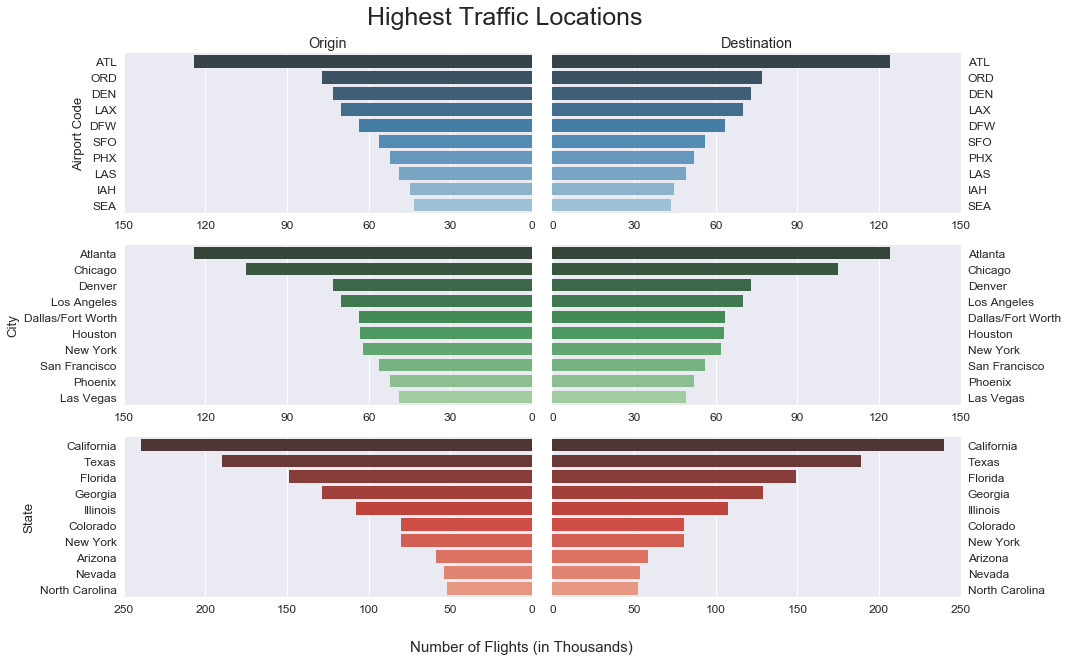

In [132]:
#plot number of flights per location identifier
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
sns.countplot(y='origin', data=topOA_df, ax=axes[0,0], order=top10_OA, palette='Blues_d')
sns.countplot(y='dest', data=topDA_df, ax=axes[0,1], order=top10_DA, palette='Blues_d')
sns.countplot(y='origin_city_name', data=topOC_df, ax=axes[1,0], order=top10_OC, palette='Greens_d')
sns.countplot(y='dest_city_name', data=topDC_df, ax=axes[1,1], order=top10_DC, palette='Greens_d')
sns.countplot(y='origin_state_nm', data=topOS_df, ax=axes[2,0], order=top10_OS, palette='Reds_d')
sns.countplot(y='dest_state_nm', data=topDS_df, ax=axes[2,1], order=top10_DS, palette='Reds_d')
axes[0,0].set(title='Origin', xlabel='', ylabel='Airport Code',xticks=np.arange(0,150001,30000),
              xticklabels=['0','30','60','90','120','150'], xlim=(0,150000))
axes[0,0].invert_xaxis()
axes[0,1].set(title='Destination', xlabel='', ylabel='', xticks=np.arange(0,150001,30000), 
              xticklabels=[str(i) for i in np.arange(0,151,30)], xlim=(0,150000))
axes[0,1].tick_params('y', labelleft=False, labelright=True)
axes[1,0].set(xlabel='', ylabel='City', xticks=np.arange(0,150001,30000), xlim=(0,150000),
             xticklabels=[str(i) for i in np.arange(0,151,30)])
axes[1,0].invert_xaxis()
axes[1,1].set(xlabel='',ylabel='',xticks=np.arange(0,150001,30000), xlim=(0,150000),
             xticklabels=[str(i) for i in np.arange(0,151,30)])
axes[1,1].tick_params('y', labelleft=False, labelright=True)
axes[2,0].set(xlabel='',ylabel='State',xticks=np.arange(0,250001,50000), xlim=(0,250000),
             xticklabels=[str(i) for i in np.arange(0,251,50)])
axes[2,0].invert_xaxis()
axes[2,1].set(xlabel='',ylabel='',xticks=np.arange(0,250001,50000),xlim=(0,250000),
             xticklabels=[str(i) for i in np.arange(0,251,50)])
axes[2,1].tick_params('y', labelleft=False, labelright=True)
fig.text(0.39, 0.05, 'Number of Flights (in Thousands)', fontsize=15)
fig.text(0.35, 0.92, 'Highest Traffic Locations', fontsize=25)
plt.subplots_adjust(wspace=0.05)
plt.savefig('Highest_traffic_locations.png')

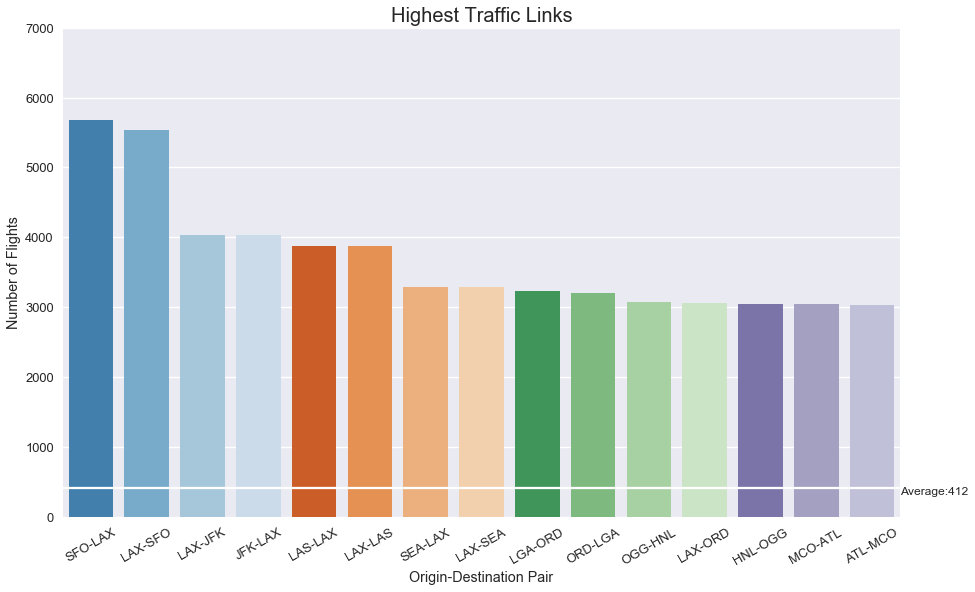

In [176]:
#plot number of flights per link
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(x="link", data=toplinks_df, palette="tab20c", ax=ax,
             order=top15_links)
ax.set(xlabel='Origin-Destination Pair', ylabel='Number of Flights', ylim=(0,7000))
ax.set_title('Highest Traffic Links', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.axhline(flights.link.value_counts().mean(), color='w')
fig.text(0.9, 0.16, 'Average:{0:.0f}'.format(flights.link.value_counts().mean()), fontsize=12)
plt.savefig('Highest_traffic_links.png')

### Flight Delays

<div class="span5 alert alert-success">
<p>A flight is counted as "on time" if it operated less than 15 minutes after the scheduled time shown in the carriers' Computerized Reservations Systems (CRS), with departure and arrival times being calculated from gate to gate, not including taxi or airtime.</p>
</div>

##### Distribution of Flight Delays

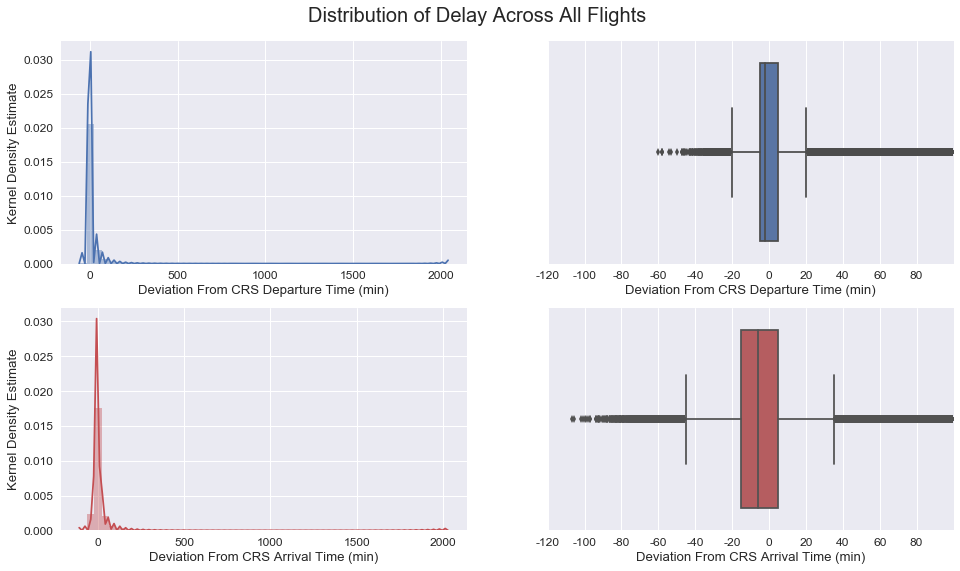

In [129]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
sns.distplot(flights['dep_deviation'], ax=axes[0,0])
sns.distplot(flights['arr_deviation'], ax=axes[1,0], color='r')
sns.boxplot(flights[flights['dep_deviation'] < 100].dep_deviation, ax=axes[0,1])
sns.boxplot(flights[flights['arr_deviation'] < 100].arr_deviation, ax=axes[1,1], color='r')
axes[0,0].set(xlabel='Deviation From CRS Departure Time (min)', ylabel='Kernel Density Estimate')
axes[0,1].set(xlabel='Deviation From CRS Departure Time (min)', xlim=(-120, 100), 
              xticks=np.arange(-120,100,20), xticklabels=[str(int(i)) for i in np.arange(-120,100,20)])
axes[1,0].set(xlabel='Deviation From CRS Arrival Time (min)', ylabel='Kernel Density Estimate')
axes[1,1].set(xlabel='Deviation From CRS Arrival Time (min)', xlim=(-120, 100), 
              xticks=np.arange(-120,100,20), xticklabels=[str(int(i)) for i in np.arange(-120,100,20)])
fig.text(0.34, 0.91, 'Distribution of Delay Across All Flights', fontsize=20)
plt.savefig('Delay_dist_all_flights.png')

##### Distribution of Delay by Carrier

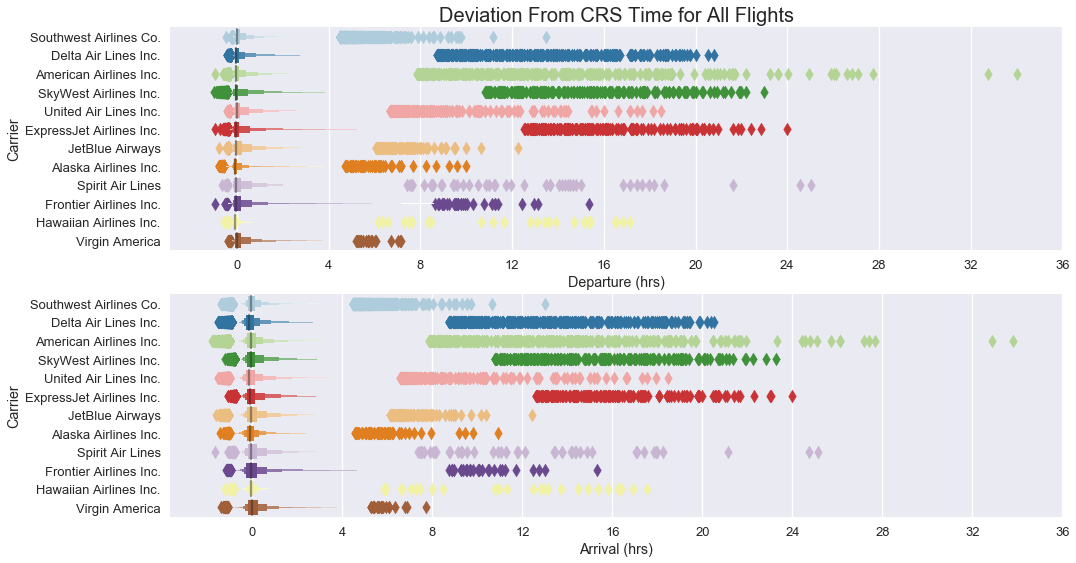

In [125]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(16,9))
sns.lvplot(y='unique_carrier_nm', x='arr_deviation', ax=ax1, data=flights,
           order=flights.unique_carrier_nm.value_counts().index.tolist(), palette='Paired')
sns.lvplot(y='unique_carrier_nm', x='dep_deviation', ax=ax0, data=flights,
           order=flights.unique_carrier_nm.value_counts().index.tolist(), palette='Paired')
ax1.set(xlabel='Arrival (hrs)', ylabel='Carrier', xticks=np.arange(0,2400,240),
        xticklabels=np.arange(0,40,4))
ax0.set(xlabel='Departure (hrs)', ylabel='Carrier', xticks=np.arange(0,2400,240),
        xticklabels=np.arange(0,40,4))
ax0.set_title('Deviation From CRS Time for All Flights', fontsize=20)
plt.savefig('Delay_dist_by_carrier.png')

##### Distribution of Delay for Highest Traffic Airports

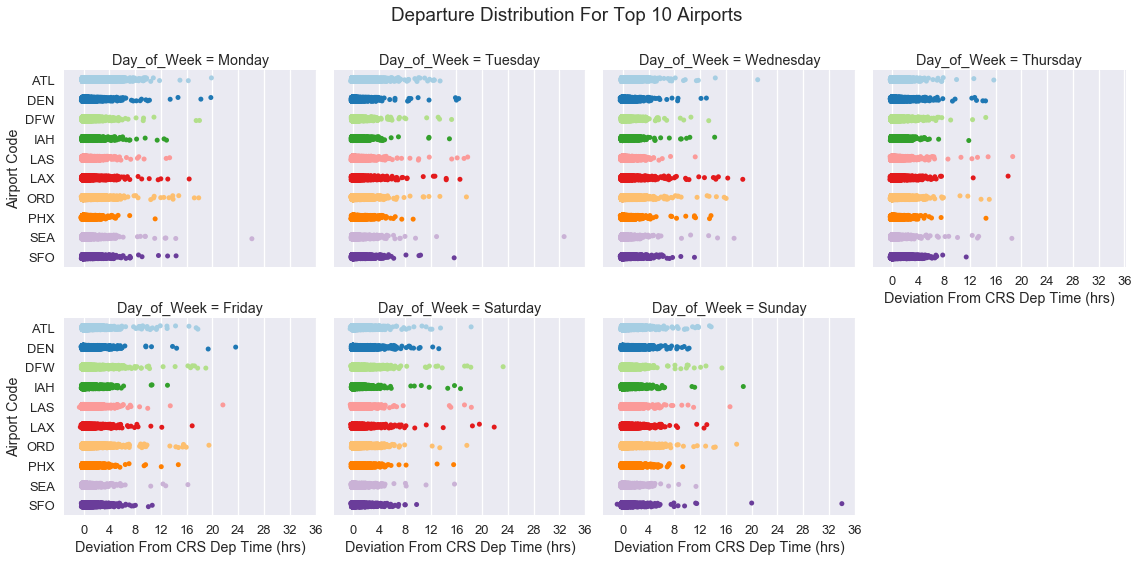

In [121]:
g = sns.factorplot(y='origin', x='dep_deviation', col ='Day_of_Week', col_wrap=4,
               data=topOA_df, kind='strip', palette='Paired', jitter=True,
               col_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
g.fig.suptitle('Departure Distribution For Top 10 Airports')
g.set(xticks=np.arange(0,2400,240), xticklabels=np.arange(0,40,4))
g.set_axis_labels('Deviation From CRS Dep Time (hrs)','Airport Code')
plt.subplots_adjust(top=0.87)
plt.savefig('Dep_dist_top_airports.png')

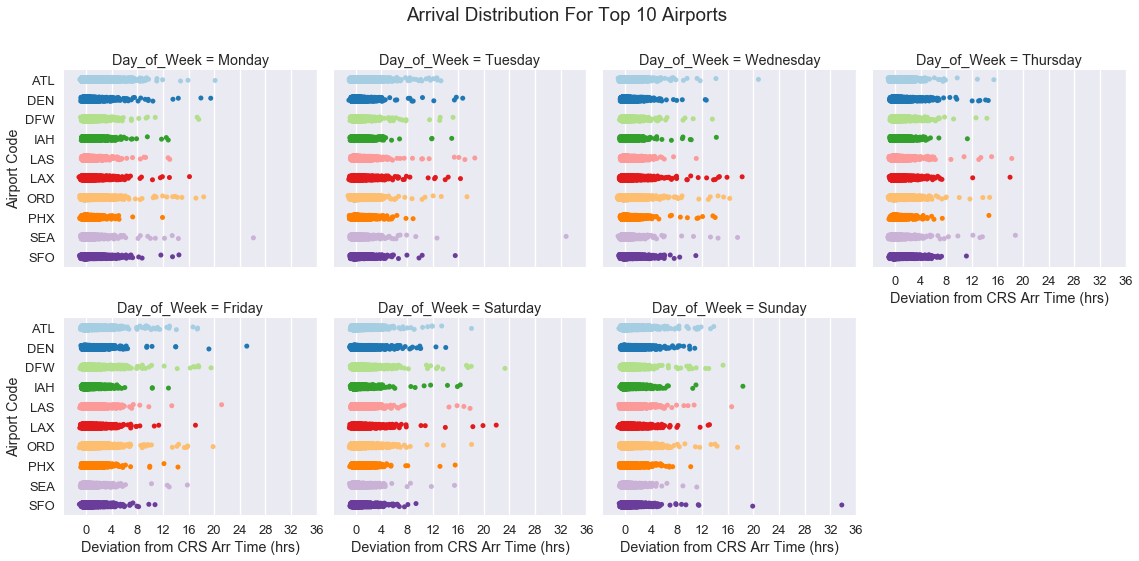

In [120]:
g = sns.factorplot(y='origin', x='arr_deviation', col ='Day_of_Week', col_wrap=4,
               data=topOA_df, kind='strip', palette='Paired', jitter=True,
               col_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.subplots_adjust(top=0.87)
g.fig.suptitle('Arrival Distribution For Top 10 Airports')
g.set(xticks=np.arange(0,2400,240), xticklabels=np.arange(0,40,4))
g.set_axis_labels('Deviation from CRS Arr Time (hrs)','Airport Code')
plt.savefig('Arr_dist_top_airports.png')

### On-Time Performance

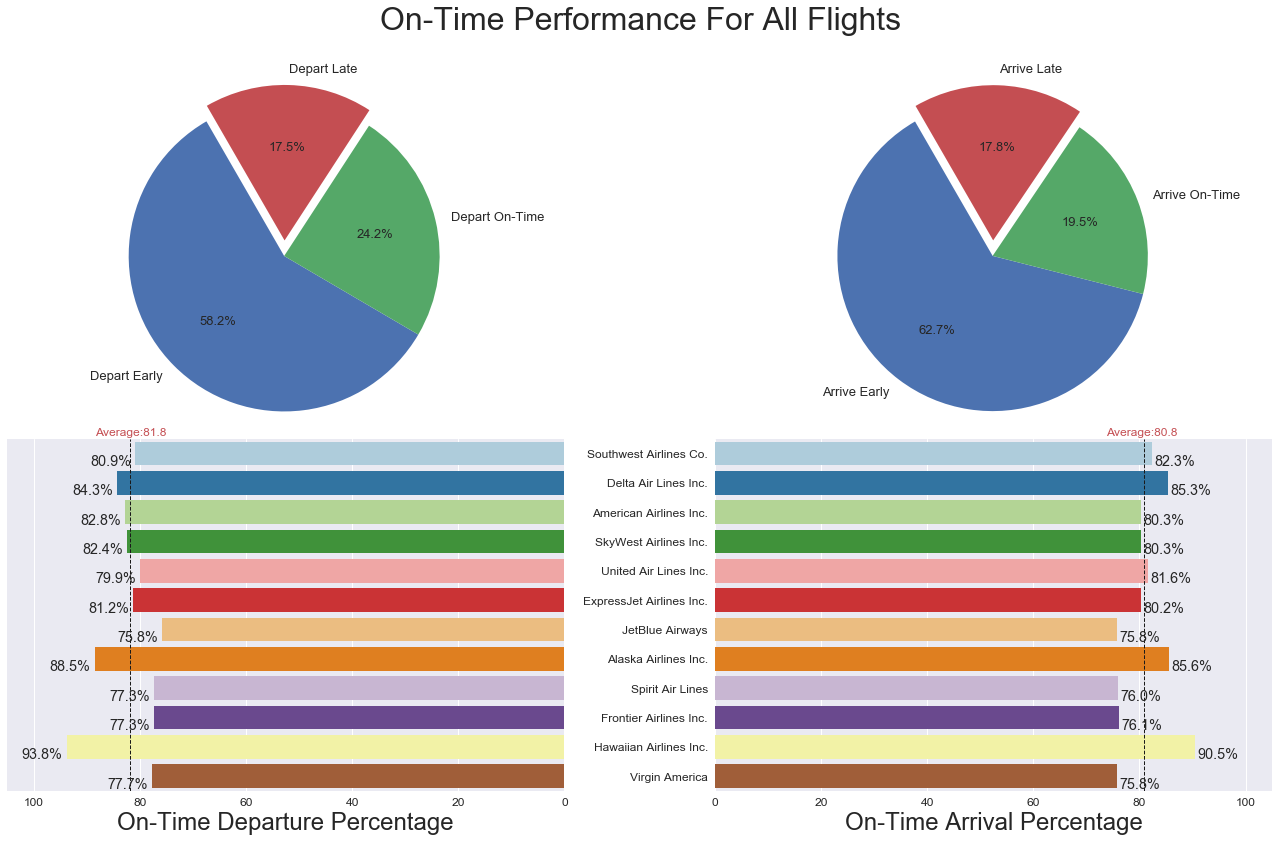

In [127]:
#define function for unpacking performance scenarios
def perf_scenarios(df, col):
    early_col = df.query('{0} < 0'.format(col))[col]
    on_time_col = df.query('{0} >= 0 & {0} <= 15'.format(col))[col]
    late_col = df.query('{0} > 15'.format(col))[col]
    return early_col, on_time_col, late_col

#get performance scenarios for departure and arrival of all flights
early_dep, on_time_dep, late_dep = perf_scenarios(flights, 'dep_deviation')
early_arr, on_time_arr, late_arr = perf_scenarios(flights, 'arr_deviation')

#define function for creating dataframe of on-time performance rates
def perf_rate_df(df, col):
    on_time = df.query('{0} < 15'.format(col))
    carrier_on_time = on_time.unique_carrier_nm.value_counts()
    total = flights.unique_carrier_nm.value_counts()
    carrier_performance = pd.DataFrame(round((carrier_on_time / total) * 100, 1))
    carrier_performance.reset_index(inplace=True)
    return carrier_performance

#get dataframes of on-time performance rates per carrier
dep_performance = perf_rate_df(flights, 'dep_deviation')
arr_performance = perf_rate_df(flights, 'arr_deviation')

#define function for adding performance rate and average to plot
def add_per(ax, df, offset):
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(p.get_width()),
                    (p.get_width()+offset, p.get_bbox().get_points()[1,1]))
    ax.axvline(df.unique_carrier_nm.mean(), color='k', linestyle='dashed', linewidth=1)

#create pie plot labels and sizes
dlabels = ['Depart Early', 'Depart On-Time', 'Depart Late']
dsizes = [len(early_dep), len(on_time_dep), len(late_dep)]
alabels = ['Arrive Early', 'Arrive On-Time', 'Arrive Late']
asizes = [len(early_arr), len(on_time_arr), len(late_arr)] 
explode = (0,0,0.1)

#plot departure and arrival on time performance
sns.set(font_scale=1.2)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
axes[0,0].pie(dsizes, labels=dlabels, autopct='%1.1f%%', shadow=False,
            explode=explode, startangle= 120, textprops={'fontsize': 13})
axes[0,0].axis('equal')
axes[0,1].pie(asizes, labels=alabels, autopct='%1.1f%%', shadow=False, 
            explode=explode, startangle= 120, textprops={'fontsize': 13})
axes[0,1].axis('equal')
sns.barplot(x='unique_carrier_nm', y='index', data=dep_performance, 
            palette='Paired', ax=axes[1,0])
axes[1,0].set(ylabel='', xticks=np.arange(0,101,20), xlim=(0,105),
              xticklabels=[str(i) for i in np.arange(0,101,20)], yticks=[])
axes[1,0].set_xlabel('On-Time Departure Percentage', fontsize=24)
axes[1,0].invert_xaxis()
add_per(axes[1,0], dep_performance, 8.5)
sns.barplot(x='unique_carrier_nm', y='index', data=arr_performance,
            palette='Paired', ax=axes[1,1])
axes[1,1].set(ylabel='', xlim=(0,105), xticks=np.arange(0,101,20),
              xticklabels=[str(i) for i in np.arange(0,101,20)])
axes[1,1].set_xlabel('On-Time Arrival Percentage', fontsize=24)
add_per(axes[1,1], arr_performance, 0.5)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.text(0.3, .95, 'On-Time Performance For All Flights', fontsize=32)
fig.text(.08, .48, 'Average:{0:.1f}'.format(dep_performance.unique_carrier_nm.mean()),
         fontsize=12, color='r') 
fig.text(.86, .48, 'Average:{0:.1f}'.format(arr_performance.unique_carrier_nm.mean()),
         fontsize=12, color='r')
plt.savefig('On_time_performance.png')

### Network Visualization

In [15]:
#show number of nodes, edges, self-loops in network
print('Number of Airports: ', len(G.nodes()))
print('Number of Origin-Destination Pairs: ', len(G.edges()))
print('Number of Self-Loops: ', G.number_of_selfloops())

Number of Airports:  309
Number of Origin-Destination Pairs:  4431
Number of Self-Loops:  0


In [104]:
#create function to get subgraph of top N number of nodes from node attribute
def subgraph_top_nodes_by_attribute(graph, N, attribute):
    lst = sorted([d[attribute] for (n,d) in graph.nodes(data=True)], reverse=True)[:N]
    top_N_nodes = [n for (n,d) in graph.nodes(data=True) if d[attribute] in lst]
    return graph.subgraph(top_N_nodes)

#create function to merge nodes in subgraph by attribute
def subgraph_nodes_merged_by_attribute(g, new_nodes, attr):
    #create subgraph from new node list by attribute
    g = g.copy()
    sub_nodes = [n for (n,d) in g.nodes(data=True) if d[attr] in new_nodes]
    sub_g = g.subgraph(sub_nodes)

    #aggregate attributes from nodes to be merged
    new_attributes = {}
    for n in new_nodes:
        new_attributes[n] = {a:d['Total Flights'] for (a,d) in sub_g.nodes(data=True) if d[attr] == n}   
    for n, d in new_attributes.items():
        total_flights = []
        for i, v in d.items():
            total_flights.append(v)
        new_attributes[n] = {'Total Flights': np.sum(total_flights), 'Nodes':list(d.keys())}

    #add new nodes and attributes to graph
    g.add_nodes_from(((i,d) for (i,d) in new_attributes.items()))

    #aggregate edges from nodes to be merged
    edges = []
    for n1,n2,d in sub_g.edges(data=True):
        for i, v in new_attributes.items():
            if n1 in v['Nodes']:
                n1 = i
            elif n2 in v['Nodes']:
                n2 = i
        edges.append((n1,n2,d))
    edge_df = pd.DataFrame(edges)
    edge_df.columns = ['origin','dest','data']
    for i,r in edge_df.iterrows():
        for k,v in r['data'].items():
            edge_df.loc[i,k] = v
    edge_gb = edge_df.groupby(['origin','dest']).sum()
    edge_dict = edge_gb.to_dict('index')
    edges = [(k[0],k[1],d) for (k,d) in edge_dict.items()]

    #add edges to new nodes
    g.add_edges_from(edges)

    #create subgraph of merged nodes
    merged_subgraph = g.subgraph(new_nodes)
    return merged_subgraph

#create function to plot subgraph 
def plot_subgraph(graph, ax, node_color, edge_cmap, title):
    pos = nx.layout.circular_layout(graph)
    node_sizes = [0.01 * v for i,v in nx.get_node_attributes(graph,'Total Flights').items()]
    edge_colors = [np.log(v) for i,v in nx.get_edge_attributes(graph,'flight_count').items()]
    edge_alphas = [v for i,v in nx.get_edge_attributes(graph,'weight').items()]
    if max(edge_alphas) > 1:
        edge_alphas = MinMaxScaler().fit_transform(np.array(edge_alphas).reshape(-1,1))
    edge_cbar = [v for i,v in nx.get_edge_attributes(graph,'flight_count').items()]
    nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_color, ax=ax)
    edges = nx.draw_networkx_edges(graph, pos, node_size=node_sizes, arrowstyle='->', ax=ax,
                               arrowsize=10, edge_color=edge_colors, edge_cmap=edge_cmap, width=2)
    labels = nx.draw_networkx_labels(graph, pos, font_size=16, font_weight='ultralight',
                                     font_family='sans-serif', font_color='k', ax=ax)
    for i in range(len(graph.edges())):
        edges[i].set_alpha(edge_alphas[i])
    pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
    pc.set_array(edge_cbar)
    cbar= plt.colorbar(pc, ax=ax)
    cbar.set_label('Number of Flights', fontsize=18)
    ax.set_title(title, fontsize=22)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [105]:
#get subgraph of top 10 nodes by total flights
top10_airports = subgraph_top_nodes_by_attribute(G, 10, 'Total Flights')

#get subgraph of top 10 nodes from previous list of top 10 cities
top10_cities = subgraph_nodes_merged_by_attribute(G, top10_OC, 'city_name')

#get subgraph of top 10 nodes from previous list of top 10 states
top10_states = subgraph_nodes_merged_by_attribute(G, top10_OS, 'state_name')

#get subgraph of top 10 nodes by degree centrality
top10_deg_cent = subgraph_top_nodes_by_attribute(G, 10, 'Degree Centrality')

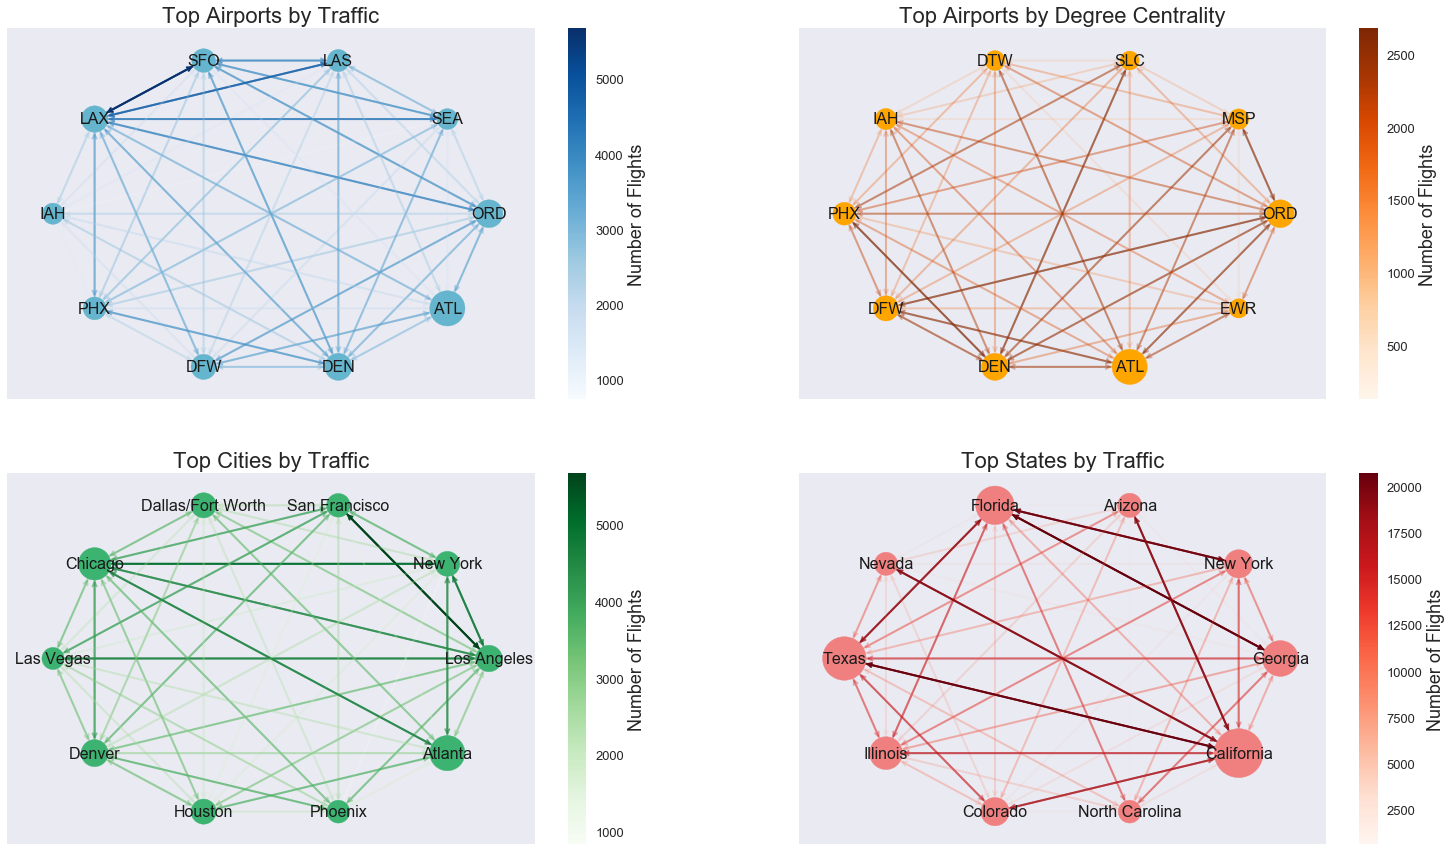

In [124]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(26, 15))
plot_subgraph(top10_airports, ax[0,0], 'c', plt.cm.Blues, 'Top Airports by Traffic')
plot_subgraph(top10_deg_cent, ax[0,1], 'orange', plt.cm.Oranges, 'Top Airports by Degree Centrality')
plot_subgraph(top10_cities, ax[1,0], 'mediumseagreen', plt.cm.Greens, 'Top Cities by Traffic')
plot_subgraph(top10_states, ax[1,1], 'lightcoral', plt.cm.Reds, 'Top States by Traffic')
plt.savefig('Network_plots.png')

# Inferential Statistics
***
1. [Test for Normality and CLT in Variables of Interest](#Test-for-Normality-and-CLT-in-Variables-of-Interest)
2. [Regression Analysis](#Regression-Analysis)
3. [Hypothesis Tests](#Hypothesis-Tests)
    - [T-Test of Arrival and Departure Deviation Means](#Difference-of-departure-and-arrival-deviation-means)
    - [Pearson's r Permutation Test of Median Arrival and Departure Delays](#Correlation-between-median-departure-delay-and-median-arrival-delay-for-Origin-Destination-Pairs)
***
[Top](#Table-of-Contents)

<div class="span5 alert alert-info">
<h3>Datasets</h3>
    <h4>Flights</h4>
        <p>- All commercial airline flights in four months of 2016</p>
    <h4>Links_d</h4>
        <p>- Origin-Destination pairs aggregated by hour of day, with categorical features dummified</p>
        <p>- Simulates a directed graph for an air-traffic network</p>
        <p>- Dataset to be used in model construction</p>
</div>

<div class="span5 alert alert-info">
<h3>Variables of Interest</h3>
    <h4>Flights Dataframe:</h4>
        <p>dep_deviation: deviation from the actual departure time to the scheduled (CRS) departure time</p>
        <p>arr_deviation: deviation from the actual arrival time to the  scheduled (CRS) arrival time</p>
    <h4>Links_d Dataframe:</h4>
        <p>dep_delay: median deviation of the actual departure time from the scheduled (CRS) departure time, for an origin-destination pair, in an hour of day that had non-zero traffic</p>
        <p>arr_delay: median deviation of the actual arrival time from the scheduled (CRS) arrival time, for an origin-destination pair, in an hour of day that had non-zero traffic</p>
</div>

### Test for Normality and CLT in Variables of Interest

Flights Sample Size:  1824403
Links_d Sample Size:  882815


[(-10, 200)]

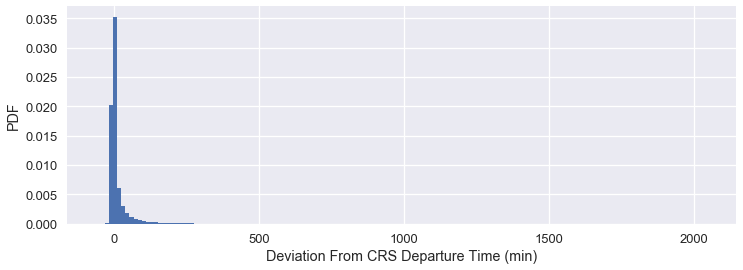

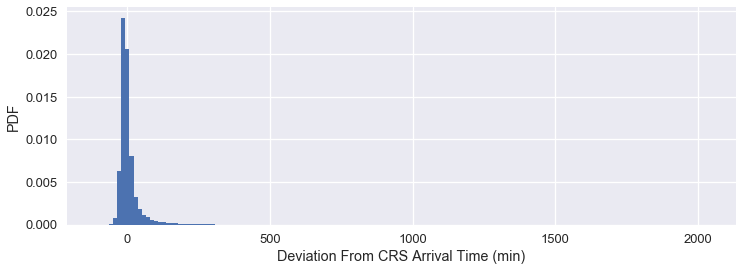

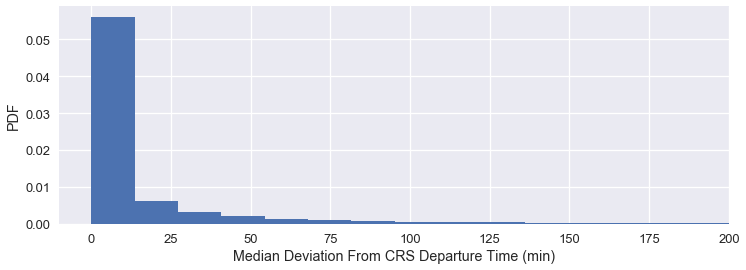

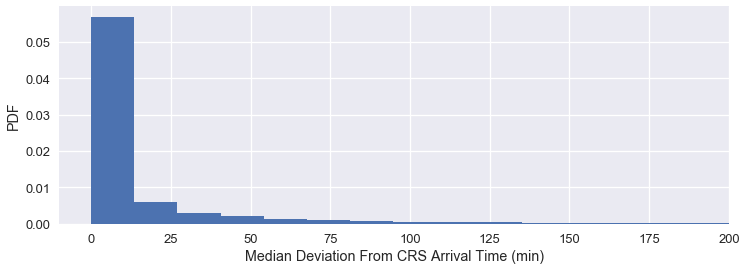

In [4]:
#check sample size 
print('Flights Sample Size: ', len(flights))
print('Links_d Sample Size: ', len(links_d))

#define function to plot probabilty density function
def pdf_plot(series, name):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.hist(series, bins=150, histtype='stepfilled', normed=True)
    ax.set(xlabel=name, ylabel='PDF')
    return ax

#plot pdf for each variable of interest
dep_deviation_pdf = pdf_plot(flights.dep_deviation, 'Deviation From CRS Departure Time (min)')
arr_deviation_pdf = pdf_plot(flights.arr_deviation, 'Deviation From CRS Arrival Time (min)')
dep_delay_pdf = pdf_plot(links_d.dep_delay, 'Median Deviation From CRS Departure Time (min)')
dep_delay_pdf.set(xlim=(-10,200))
arr_delay_pdf = pdf_plot(links_d.arr_delay, 'Median Deviation From CRS Arrival Time (min)')
arr_delay_pdf.set(xlim=(-10,200))

<div class="span5 alert alert-success">
<p>Central Limit Theorem applies as sample size is very large and the probability density function of each variable shows observations are independent</p>
</div>

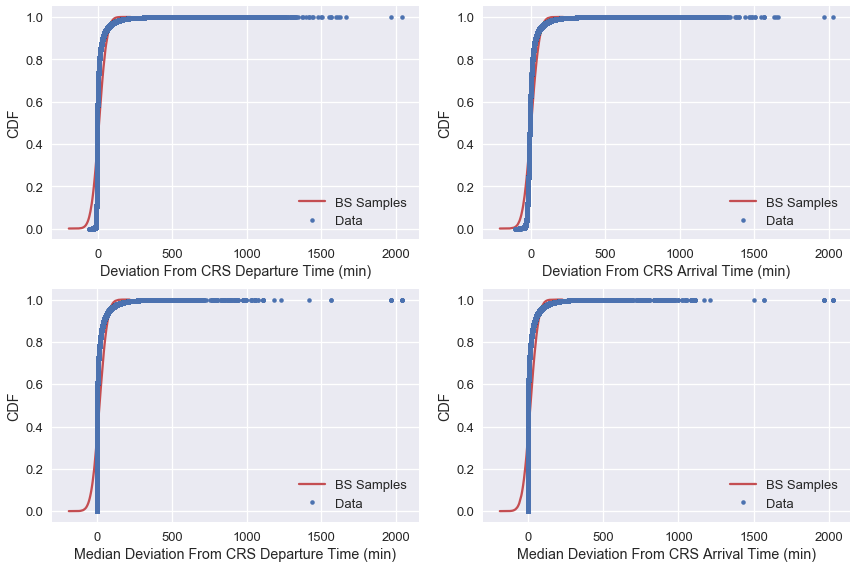

In [21]:
#define function for plotting cdf and ecdf
def cdf_plot(series, name, ax):
    mean = series.mean()
    std = series.std()
    samples = np.random.normal(mean, std, size=len(series))
    def ecdf(data):
        n = len(data)
        x = np.sort(data)
        y = np.arange(1, n+1) / n
        return x, y
    x_theor, y_theor = ecdf(samples)
    x, y = ecdf(series)
    ax.plot(x_theor, y_theor, color='r')
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set(xlabel=name, ylabel='CDF')
    ax.legend(('BS Samples', 'Data'), loc='lower right')

#show cdf and ecdf for variables of interest
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
cdf_plot(flights.dep_deviation, 'Deviation From CRS Departure Time (min)', ax=axes[0,0])
cdf_plot(flights.arr_deviation, 'Deviation From CRS Arrival Time (min)', ax=axes[0,1])
cdf_plot(links_d.dep_delay, 'Median Deviation From CRS Departure Time (min)', ax=axes[1,0])
cdf_plot(links_d.arr_delay, 'Median Deviation From CRS Arrival Time (min)', ax=axes[1,1])
fig.tight_layout()
plt.savefig('Deviation_cdf_plots.png')

<div class="span5 alert alert-success">
<p>The Cumulative Density Function of each variable shows they all possess normal distributions</p>
</div>

### Regression Analysis

<div class="span5 alert alert-info">
For the purpose of validating a directed network approach utilizing only departure delay as a predictor of overall (departure and arrival) delay
</div>

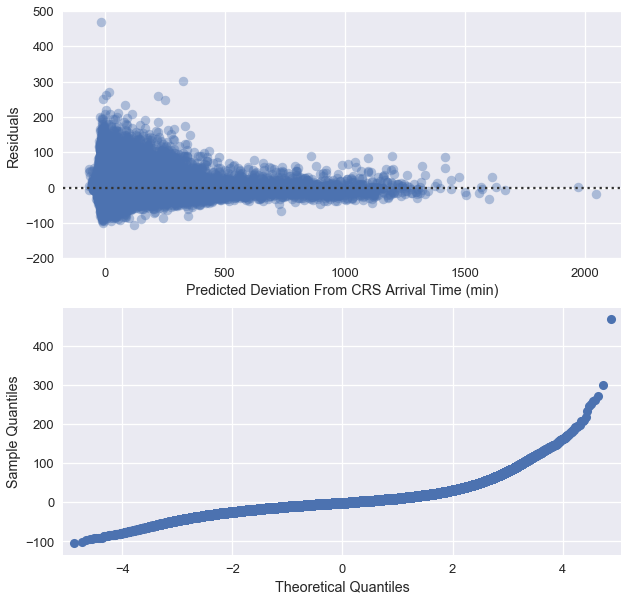

In [2]:
arr_from_dep = ols('arr_deviation ~ dep_deviation', flights).fit()

#plot the residuals and the quantile plot of the regression analysis for departure and arrival deviation
fig, axes = plt.subplots(nrows=2, figsize=(10,10))
sns.residplot(arr_from_dep.fittedvalues, arr_from_dep.resid, ax=axes[0],
              scatter_kws={'alpha':.4, 's': 90})
sm.qqplot(arr_from_dep.resid, ax=axes[1])
axes[0].set(xlabel='Predicted Deviation From CRS Arrival Time (min)',
       ylabel='Residuals',
       ylim=(-200,500))
plt.savefig('Residuals.png')

<div class="span5 alert alert-success">
<p>The residuals between departure and arrival deviation are in a random pattern, supporting the use of a linear model. The quantile plot shows that the datasets are heavily skewed, and robust methods should be used in model construction to lessen the influence of extreme values.</p>
</div>

Text(0.27,1,'Regression Model for Departure and Arrival Deviation By Date')

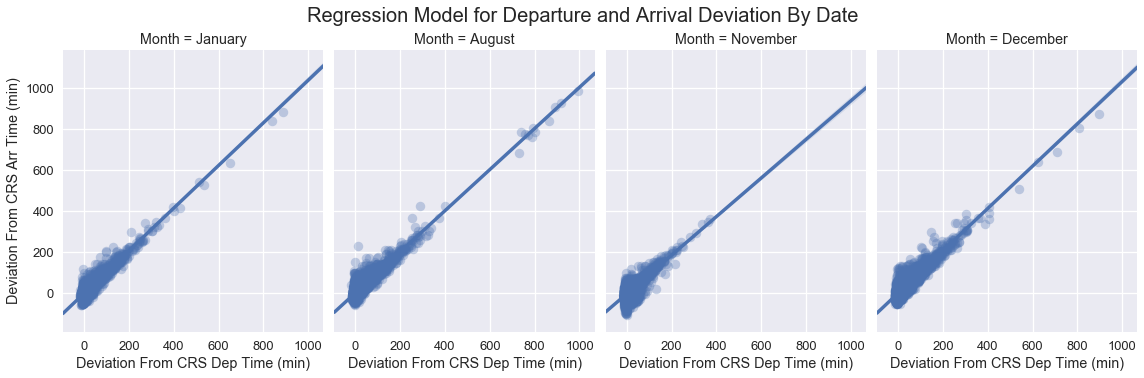

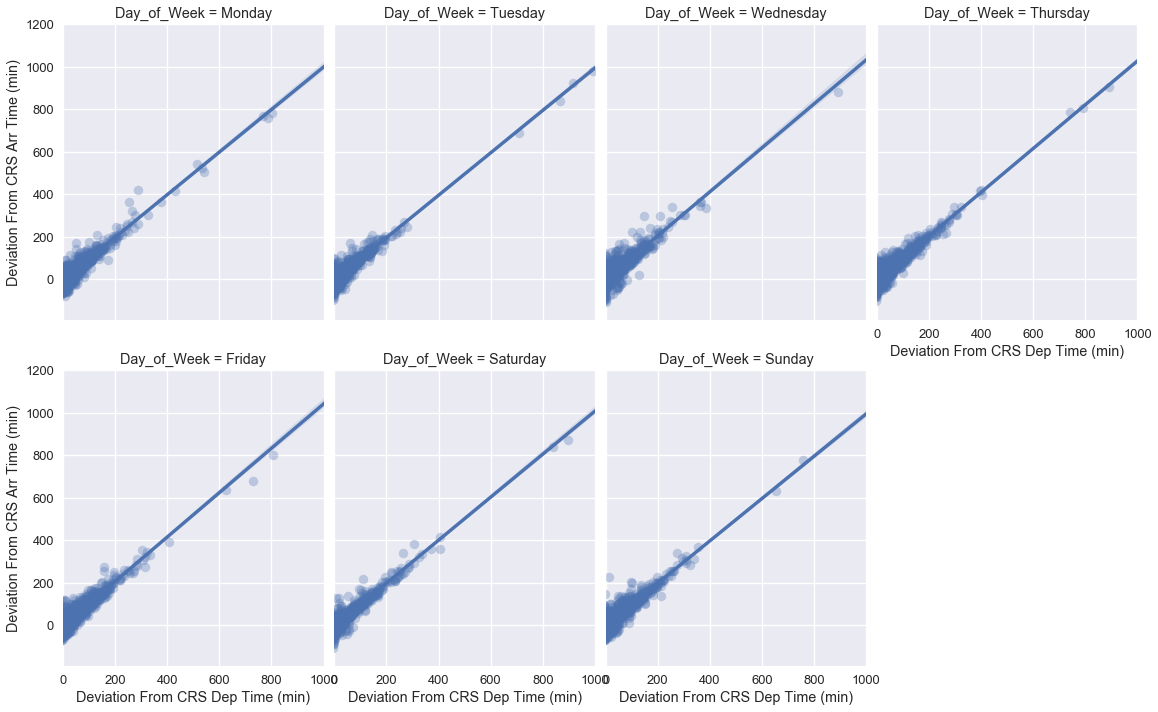

In [7]:
#define function for getting list and dataframe slice of top n values in column
def top_nvals(series, data, size):
    ntop_counts = series.value_counts()
    ntop_lst = ntop_counts.nlargest(size).index.tolist()
    ntop_df = data.loc[series.isin(ntop_counts[:size].index.tolist())]
    return ntop_lst, ntop_df

#unpack dataframe and list of top 5 links
top5_links, top5links_df = top_nvals(flights.link, flights, 5)

#plot dep and arr deviation by month
g1 = sns.lmplot(x='dep_deviation', y='arr_deviation', col='Month', col_wrap=4, aspect=.8,
                col_order=['January', 'August', 'November', 'December'], data=top5links_df,
                palette='Paired', scatter_kws={'alpha': .3, 's': 90})
g1.set_axis_labels('Deviation From CRS Dep Time (min)', 'Deviation From CRS Arr Time (min)')

#plot dep and arr deviation by day of week
g = sns.lmplot(x='dep_deviation', y='arr_deviation', col='Day_of_Week', aspect=.8,
              col_wrap=4, col_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              palette='Paired', data=top5links_df, scatter_kws={'alpha': .3, 's':90})
g.set(xlim=(0,1000))
g.set_axis_labels('Deviation From CRS Dep Time (min)', 'Deviation From CRS Arr Time (min)')
g1.fig.text(0.27, 1, 'Regression Model for Departure and Arrival Deviation By Date', fontsize=20)

<div class="span5 alert alert-success">
<p>A regression analysis showed that in each categorical date value, deviation from CRS departure and arrival time shared a positive correlation </p>
</div>

### Hypothesis Tests

##### Difference of departure and arrival deviation means

<div class="span5 alert alert-info">
<p>Ho : $\mu_{d}$ = $\mu_{a}$  </p>
<p>Ha : $\mu_{d}$ $\neq$ $\mu_{a}$ </p>
</div>

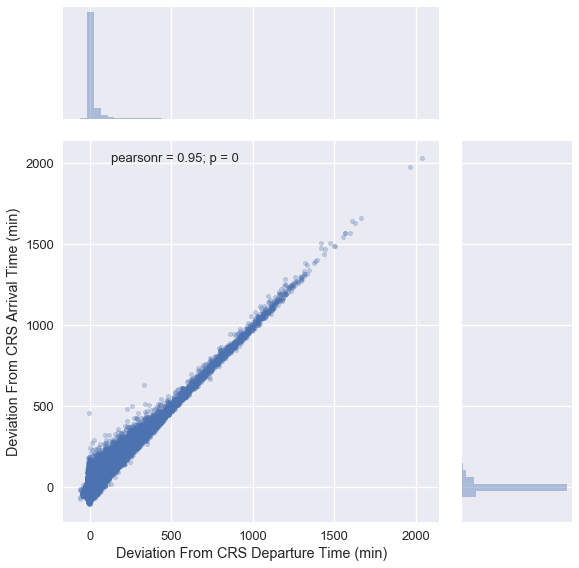

In [19]:
#display distribution and pearsonr for departure and arrival
g = sns.jointplot(x='dep_deviation', y='arr_deviation', data=flights,
                   size=8, ratio=3, kind="scatter", joint_kws={'alpha':0.3,'s': 20})
g.set_axis_labels("Deviation From CRS Departure Time (min)", 
                  "Deviation From CRS Arrival Time (min)")

In [9]:
#define function to calculate an independent samples ttest 
def ttest_of_means(series1, name1, series2, name2):
    sem = round(np.sqrt(((series1.std() ** 2) / len(series1)) + 
                        ((series2.std() ** 2) / len(series2))), 3)
    dom = round(np.abs(np.mean(series1) - np.mean(series2)), 3)
    print('Margin of Error: ', sem)
    print('Difference of Means: ', dom)
    print(name1,' 95% Confidence Interval: ', np.percentile(series1,[2.5, 97.5]), 'min')
    print(name2,' 95% Confidence Interval: ', np.percentile(series2, [2.5, 97.5]), 'min')
    print('T-Test: tstat = %6.3f, P-value = %6.10f' % stats.ttest_ind(series2, series1))

#calculate significance of difference of means for departure and arrival deviation
ttest_of_means(flights.dep_deviation,'Departure Deviation',
               flights.arr_deviation, 'Arrival Deviation')

Margin of Error:  0.045
Difference of Means:  5.549
Departure Deviation  95% Confidence Interval:  [-11. 112.] min
Arrival Deviation  95% Confidence Interval:  [-31. 112.] min
T-Test: tstat = -124.015, P-value = 0.0000000000


<div class="span5 alert alert-success">
<p>With an alpha level of .01 ($\alpha$ = .01), the difference between the means of departure and arrival deviation from scheduled (CRS) time was statistically significant, p < .01</p>
</div>

##### Correlation between median departure delay and median arrival delay for Origin-Destination Pairs

<div class="span5 alert alert-info">
<p>Ho : The correlation between the current median departure delay and median arrival delay for an Origin-Destination pair is not significant</p>
<p>Ha : The correlation between the current median departure delay and median arrival delay for an Origin-Destination pair is significant</p>
</div>

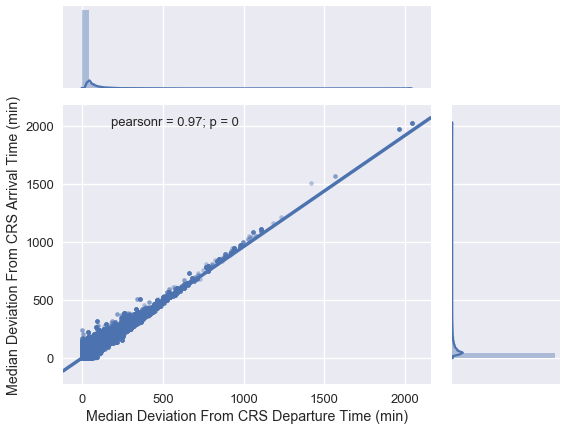

In [33]:
#display distribution and pearsonr for distance and arrival delay
g = sns.jointplot(x='dep_delay', y='arr_delay', data=links_d, size=8,
                  ratio=3, kind='reg', scatter_kws={'alpha':0.4,'s': 20})
g.set_axis_labels('Median Deviation From CRS Departure Time (min)',
                  'Median Deviation From CRS Arrival Time (min)')
plt.gcf().set_size_inches(8, 6)
plt.savefig('Median_arr_vs_dep_deviation.png')

In [11]:
#define function to test for signficance of a correlation
def pearsonr_perm_test(x, y, size):
    pearson_r = np.corrcoef(x,y)[0,1]
    perm_replicates = np.empty(size)
    for i in range(size):
        x_perm = np.random.permutation(x)
        perm_replicates[i] = np.corrcoef(x_perm, y)[0,1]
    p = np.sum(perm_replicates >= pearson_r) / len(perm_replicates)
    return pearson_r, p 

#show correlation coefficient and p-value
print('Pearson Correlation Coefficient: r = %6.3f, P-value = %6.8f' % 
      pearsonr_perm_test(links_d.arr_delay, links_d.dep_delay, 1000))

Pearson Correlation Coefficient: r =  0.971, P-value = 0.00000000


<div class="span5 alert alert-success">
<p>With an alpha level of .01 ($\alpha$ = .01), the correlation between the median departure delay and the median arrival delay for Origin-Destination pairs is statistically significant, p < .01</p>
</div>

# Model Construction
Binary Departure Delay Classification 
***
1. [Baseline](#Baseline-Logistic-Regression-Classifier)
    - [Initial Results](#Initial-Results:)
2. [Final Models on Resampled Datasets](#Resampling-to-counter-dataset-imbalance)
    - [Condition 1: Under-sampling](#Condition-1:-Random-Under-sampling)
        - [Logistic Regression](#Logistic-Regression-Classifier-with-Undersampled-dataset)
        - [Random Forest](#Random-Forest-Classifier-with-Undersampled-dataset)
    - [Condition 2: Over-sampling](#Condition-2:-Synthetic-Minority-Over-sampling-Technique)
        - [Logistic Regression](#Logistic-Regression-with-Oversampled-dataset)
        - [Random Forest](#Random-Forest-Classifier-with-Oversampled-dataset)
    - [Final Results](#Final-Results:)
***
[Top](#Table-of-Contents)

In [2]:
#define function to partition data into standardized train and test sets
def train_test_scaled(df, featurenames, target, size, scaler, standardize=False):   
    subdf=df[featurenames].reset_index(drop=True)
    if standardize:
        scale = scaler.fit(subdf)
        subdfstd = scale.transform(subdf)
    else: 
        subdfstd=df
    X=subdfstd
    y=df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, stratify=y)
    return X_train, X_test, y_train, y_test, scale

#define function to get values for classifier predictions
def get_pred_prob(clf, Xtr, Xts):
    ytr_pred = clf.predict(Xtr)
    yts_pred = clf.predict(Xts)
    yts_prob = clf.predict_proba(Xts)
    return ytr_pred, yts_pred, yts_prob

#define function to get scores for classifier
def classification_metrics(clf, Xtr, ytr, ytr_pred, Xts, yts, yts_pred):
    train_scores = cross_val_score(clf, Xtr, ytr, cv=5)
    test_scores = cross_val_score(clf, Xts, yts, cv=5)
    print('-'*52)
    print('CV-Accuracy on training data: {:0.4f} (+/- {:0.4f})'.format(train_scores.mean(), train_scores.std() * 2))
    print('CV-Accuracy on test data: {:0.4f} (+/- {:0.4f})'.format(test_scores.mean(), test_scores.std() * 2))
    print('-'*52)
    print("[Training Classification Report]")
    print(classification_report(ytr, ytr_pred))
    print('-'*52)
    print("[Test Classification Report]")
    print(classification_report(yts, yts_pred))
    print('-'*52)
    
#define function to plot metrics for Logistic Regression model
def logreg_metrics_plots(clf, Xtr, ytr, Xts, yts, yts_pred, yts_probs):
    fig, axes = plt.subplots(nrows=7, figsize=(9, 30))
    skplt.metrics.plot_cumulative_gain(yts, yts_probs, ax=axes[0])
    skplt.metrics.plot_lift_curve(yts, yts_probs, ax=axes[1])
    skplt.metrics.plot_ks_statistic(yts, yts_probs, ax=axes[2])
    skplt.metrics.plot_roc(yts, yts_probs, ax=axes[3])
    skplt.metrics.plot_precision_recall(yts, yts_probs, ax=axes[4])
    skplt.metrics.plot_calibration_curve(yts,[yts_probs],['Logistic Regression'], ax=axes[5])
    skplt.metrics.plot_confusion_matrix(yts, yts_pred, normalize=True, ax=axes[6])
    fig.tight_layout()
    plt.show()
    
#define function to plot metrics for Random Forest Classifier
def randforest_metrics_plots(clf, Xtr, ytr, Xts, yts, yts_pred, yts_probs):
    fig, axes = plt.subplots(nrows=4, figsize=(9, 20))
    skplt.metrics.plot_roc(yts, yts_probs, ax=axes[0])
    skplt.metrics.plot_precision_recall(yts, yts_probs, ax=axes[1])
    skplt.metrics.plot_calibration_curve(yts,[yts_probs],['Random Forest'], ax=axes[2])
    skplt.metrics.plot_confusion_matrix(yts, yts_pred, normalize=True, ax=axes[3])
    fig.tight_layout()
    plt.show()

## Baseline Logistic Regression Classifier

In [7]:
#split data into standardized train and test sets
X_train, X_test, y_train, y_test, scale = train_test_scaled(links_d, features,'dd_binary', 0.3,
                                                            RobustScaler(), standardize=True)

In [ ]:
#store train/test splits for binary classification
for k, v in {'Xtrain': X_train, 'Xtest': X_test, 'ytrain': y_train, 'ytest': y_test, 'scale': scale}.items():
    joblib.dump(v, 'CP1_binary_{}.pkl'.format(k)) 

In [7]:
#load test splits and scale object for binary classification
X_test = joblib.load('CP1_binary_Xtest.pkl')
y_test = joblib.load('CP1_binary_ytest.pkl')

In [8]:
#fit training data to Logistic Regression estimator without regularization
lr = LogisticRegression().fit(X_train, y_train)

In [9]:
#get values for unregularized model predictions
y_train_pred, y_test_pred, y_test_prob = get_pred_prob(lr, X_train, X_test)
    
#get classification metrics for unregularized model
print('Classification Metrics for Baseline Logistic Regression Model')
classification_metrics(lr, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred)

Classification Metrics for Baseline Logistic Regression Model
----------------------------------------------------
CV-Accuracy on training data: 0.7721 (+/- 0.0000)
CV-Accuracy on test data: 0.7721 (+/- 0.0000)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.77      1.00      0.87    477153
          1       0.00      0.00      0.00    140817

avg / total       0.60      0.77      0.67    617970

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.77      1.00      0.87    204495
          1       0.00      0.00      0.00     60350

avg / total       0.60      0.77      0.67    264845

----------------------------------------------------


c:\programdata\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Set Results with Unregularized Logistic Regression


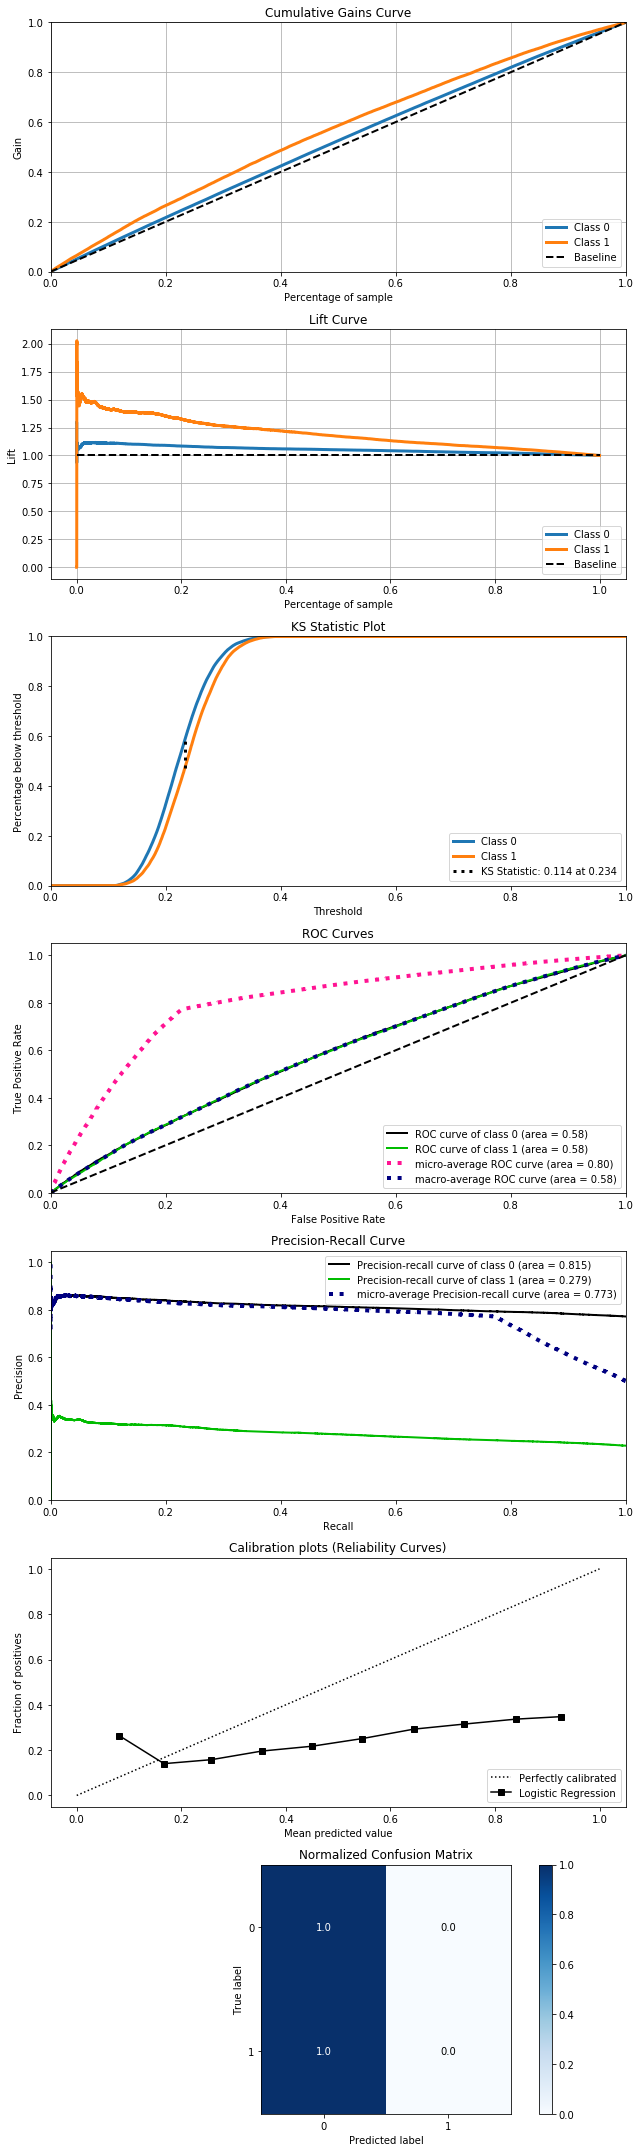

In [10]:
#plot metrics of unregularized model
print('Test Set Results with Unregularized Logistic Regression')
logreg_metrics_plots(lr, X_train, y_train, X_test, y_test, y_test_pred, y_test_prob)

#####  Initial Results:
- Due to the imbalanced distribution of the delayed class (22.7% of total dataset) the classifier performed very poorly in predicting true positives
- Accuracy was deemed to be an inappropriate evaluation metric in this case, with the individual Precision, Recall, and F1-scores for each class being more indicative of model performance.

## Resampling to counter dataset imbalance
- Utilize Under- and Over- sampling techniques on the training dataset
- Train each method on RandomForest and Logistic Regression classifiers
- Test Classifiers under both conditions and perform cross-validation with the test set containing the natural distribution of classes
- Assess model performance with Precision, Recall, F-1, and AUC scores.  Particularly the Area under the ROC curve statistic, as it is equal to the probability that a random positive example will be ranked above a random negative example, and the Precision-Recall curve as a visual metric.

### Condition 1: Random Under-sampling

In [6]:
from imblearn.under_sampling import RandomUnderSampler

#under sample training and test sets
Xtr_rus, ytr_rus = RandomUnderSampler(random_state=42).fit_sample(X_train, y_train)

#show resample shape vs original shape
print('Original target shape:  {}'.format(Counter(y_train)))
print('Resampled target shape:  {}'.format(Counter(ytr_rus)))

Original target shape:  Counter({0: 477153, 1: 140817})
Resampled target shape:  Counter({0: 140817, 1: 140817})


In [15]:
#store undersampled training data for binary classification
for k, v in {'Xtr_rus': Xtr_rus, 'ytr_rus': ytr_rus}.items():
    joblib.dump(v, 'CP1_binary_{}.pkl'.format(k)) 

In [9]:
#load undersampled training data for binary classification
Xtr_rus = joblib.load('CP1_binary_Xtr_rus.pkl')
ytr_rus = joblib.load('CP1_binary_ytr_rus.pkl')

#### Logistic Regression Classifier with Undersampled dataset

In [15]:
#train logistic regression
lr_rus = LogisticRegression().fit(Xtr_rus, ytr_rus)

In [16]:
#get values for undersampled logistic regression model predictions
ytr_rus_pred, yts_rus_pred, yts_rus_prob = get_pred_prob(lr_rus, Xtr_rus, X_test)

#get classification metrics for undersampled logistic regression model
print('Classification Metrics on Undersampled Logistic Regression Model')
classification_metrics(lr_rus, Xtr_rus, ytr_rus, ytr_rus_pred, X_test, y_test, yts_rus_pred)

Classification Metrics on Undersampled Logistic Regression Model
----------------------------------------------------
Accuracy on training data: 0.5540 (+/- 0.0050)
Accuracy on test data: 0.7721 (+/- 0.0000)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.56      0.54      0.55    140817
          1       0.56      0.58      0.57    140817

avg / total       0.56      0.56      0.56    281634

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.81      0.53      0.64    204495
          1       0.27      0.57      0.36     60350

avg / total       0.69      0.54      0.58    264845

----------------------------------------------------


Test Set Results with Undersampled Logistic Regression Model


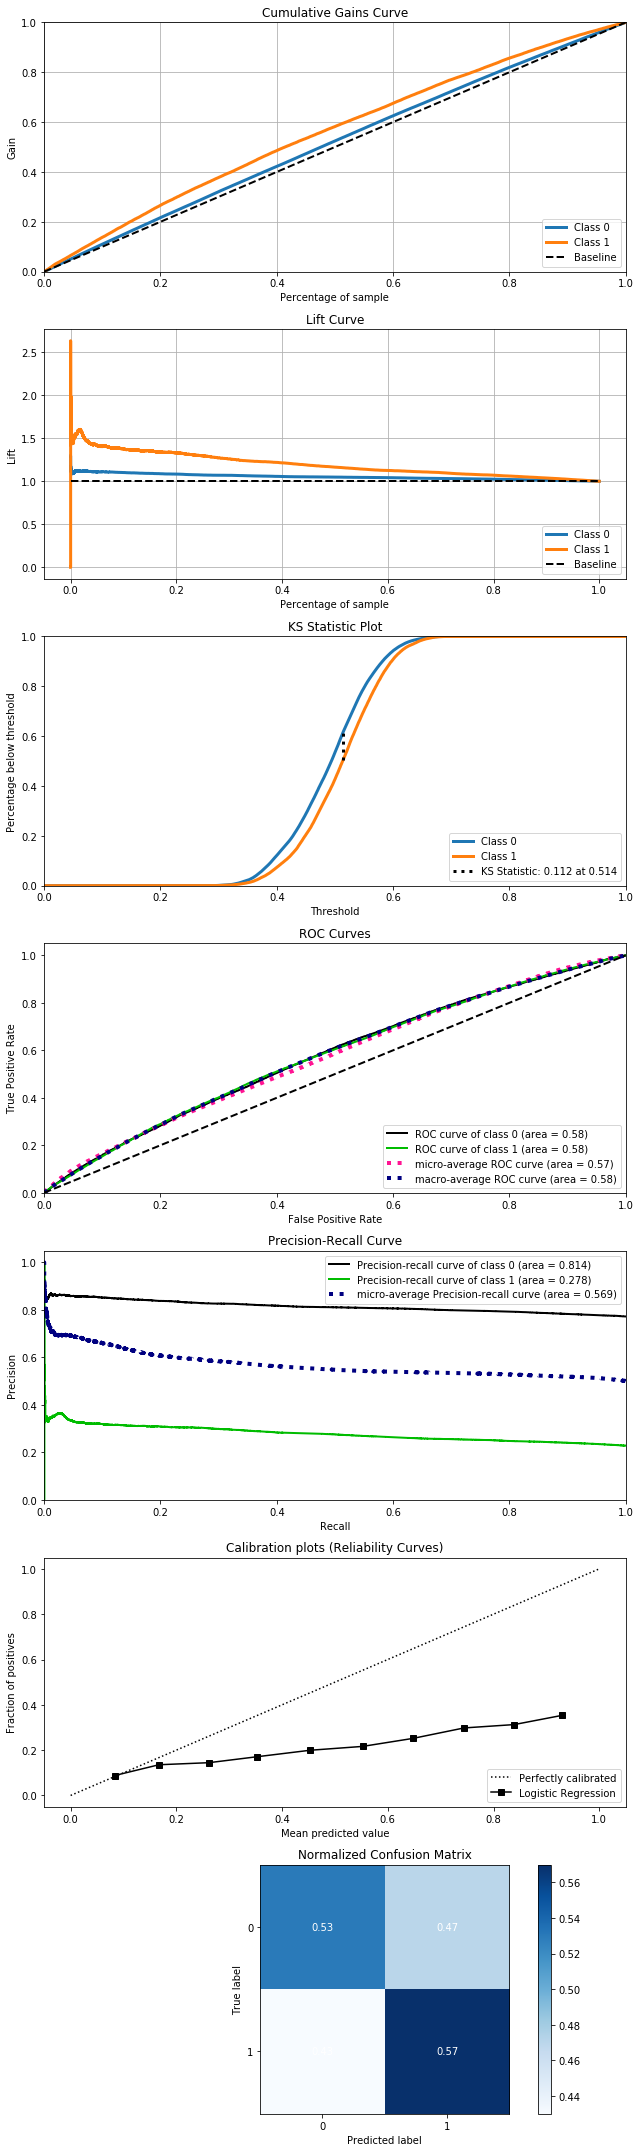

In [17]:
#plot metrics of undersampled lr model
print('Test Set Results with Undersampled Logistic Regression Model')
logreg_metrics_plots(lr_rus, Xtr_rus, ytr_rus, X_test, y_test, yts_rus_pred, yts_rus_prob)

#### Random Forest Classifier with Undersampled dataset

In [7]:
#create hyperparameter grid
rf_params = {'n_estimators':  [100], 'max_features':[0.2, 'log2', 0.4]}

#Random Forest Classifier on undersampled training data using GridSearchCV
GSCV_Rf_rus = GridSearchCV(RandomForestClassifier(), rf_params, n_jobs=2, cv=3).fit(Xtr_rus, ytr_rus)

In [8]:
#get best Random forest estimator from GSCV 
best_Rf_rus = GSCV_Rf_rus.best_estimator_

#Show results of RandomForest GSCV on undersampled dataset
print("Tuned Model Parameters: {}".format(GSCV_Rf_rus.best_params_))
print("Best GSCV score on Training Set: {:0.4f}".format(GSCV_Rf_rus.best_score_))

Tuned Model Parameters: {'max_features': 'log2', 'n_estimators': 100}
Best GSCV score on Training Set: 0.7398


In [9]:
#store Random Forest Classifier trained on Undersampled Data
joblib.dump(best_Rf_rus, 'CP1_binary_RandomForestClassifier_rus.pkl')

['CP1_binary_RandomForestClassifier_rus.pkl']

In [10]:
#load Random Forest Classifier trained on Undersampled Data
best_Rf_rus = joblib.load('CP1_binary_RandomForestClassifier_rus.pkl')

In [11]:
#get predicted values for best RandomForest estimator on undersampled dataset
ytr_rus_pred, yts_rus_pred, yts_rus_prob = get_pred_prob(best_Rf_rus, Xtr_rus, X_test)

#get classification metrics for best RandomForest GSCV estimator
print('Classification Metrics for Undersampled Random Forest Classifier')
classification_metrics(best_Rf_rus, Xtr_rus, ytr_rus, ytr_rus_pred, X_test, y_test, yts_rus_pred)

Classification Metrics for Undersampled Random Forest Classifier
----------------------------------------------------
CV-Accuracy on training data: 0.7529 (+/- 0.0028)
CV-Accuracy on test data: 0.8093 (+/- 0.0025)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.94      0.93      0.94    140817
          1       0.93      0.94      0.94    140817

avg / total       0.94      0.94      0.94    281634

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.92      0.76      0.83    204495
          1       0.49      0.77      0.60     60350

avg / total       0.82      0.76      0.78    264845

----------------------------------------------------


Test Set Results with Undersampled Random Forest Classifier


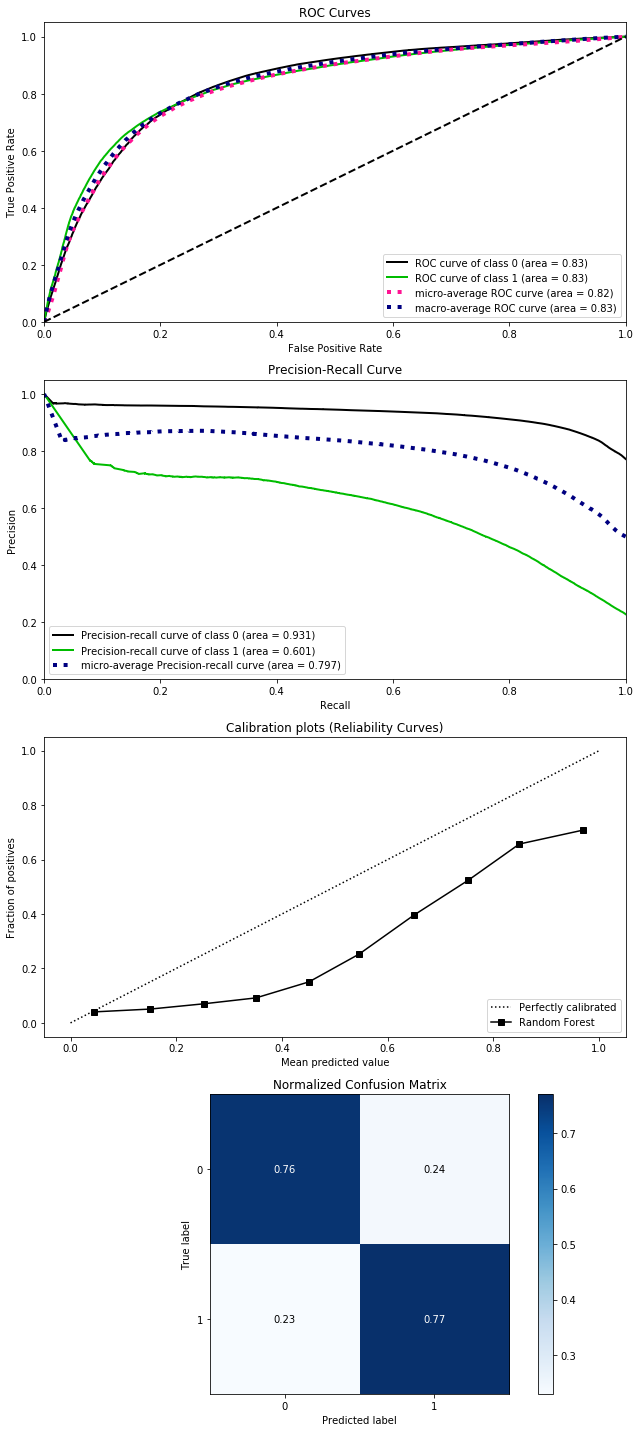

In [12]:
#plot metrics of undersampled RandomForest Classifier
print('Test Set Results with Undersampled Random Forest Classifier')
randforest_metrics_plots(best_Rf_rus, Xtr_rus, ytr_rus, X_test, y_test, yts_rus_pred, yts_rus_prob)

### Condition 2: Synthetic Minority Over-sampling Technique

In [17]:
from imblearn.over_sampling import SMOTE

#under sample training and test sets
Xtr_smote, ytr_smote = SMOTE(ratio='minority', n_jobs=2).fit_sample(X_train, y_train)

#show resample shape vs original shape
print('Original target shape:  {}'.format(Counter(y_train)))
print('Resampled target shape:  {}'.format(Counter(ytr_smote)))

Original target shape:  Counter({0: 477153, 1: 140817})
Resampled target shape:  Counter({0: 477153, 1: 477153})


In [18]:
#store oversampled training data for binary classification
for k, v in {'Xtr_smote': Xtr_smote, 'ytr_smote': ytr_smote}.items():
    joblib.dump(v, 'CP1_binary_{}.pkl'.format(k)) 

In [8]:
#load oversampled training data for binary classification
Xtr_smote = joblib.load('CP1_binary_Xtr_smote.pkl')
ytr_smote = joblib.load('CP1_binary_ytr_smote.pkl')

#### Logistic Regression with Oversampled dataset

In [23]:
#train logistic regression
lr_smote = LogisticRegression().fit(Xtr_smote, ytr_smote)

In [24]:
#get values for oversampled logistic regression model predictions
ytr_smote_pred, yts_smote_pred, yts_smote_prob = get_pred_prob(lr_smote, Xtr_smote, X_test)
    
#get classification metrics for oversampled logistic regression model
print('Classification Metrics on Oversampled Logistic Regression Model')
classification_metrics(lr_smote, Xtr_smote, ytr_smote, ytr_smote_pred, X_test, y_test, yts_smote_pred)

Classification Metrics on Oversampled Logistic Regression Model
----------------------------------------------------
Accuracy on training data: 0.5570 (+/- 0.0012)
Accuracy on test data: 0.7721 (+/- 0.0000)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.56      0.54      0.55    477153
          1       0.56      0.58      0.57    477153

avg / total       0.56      0.56      0.56    954306

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.81      0.54      0.65    204495
          1       0.27      0.57      0.36     60350

avg / total       0.69      0.55      0.58    264845

----------------------------------------------------


Test Set Results with Oversampled Logistic Regression Model


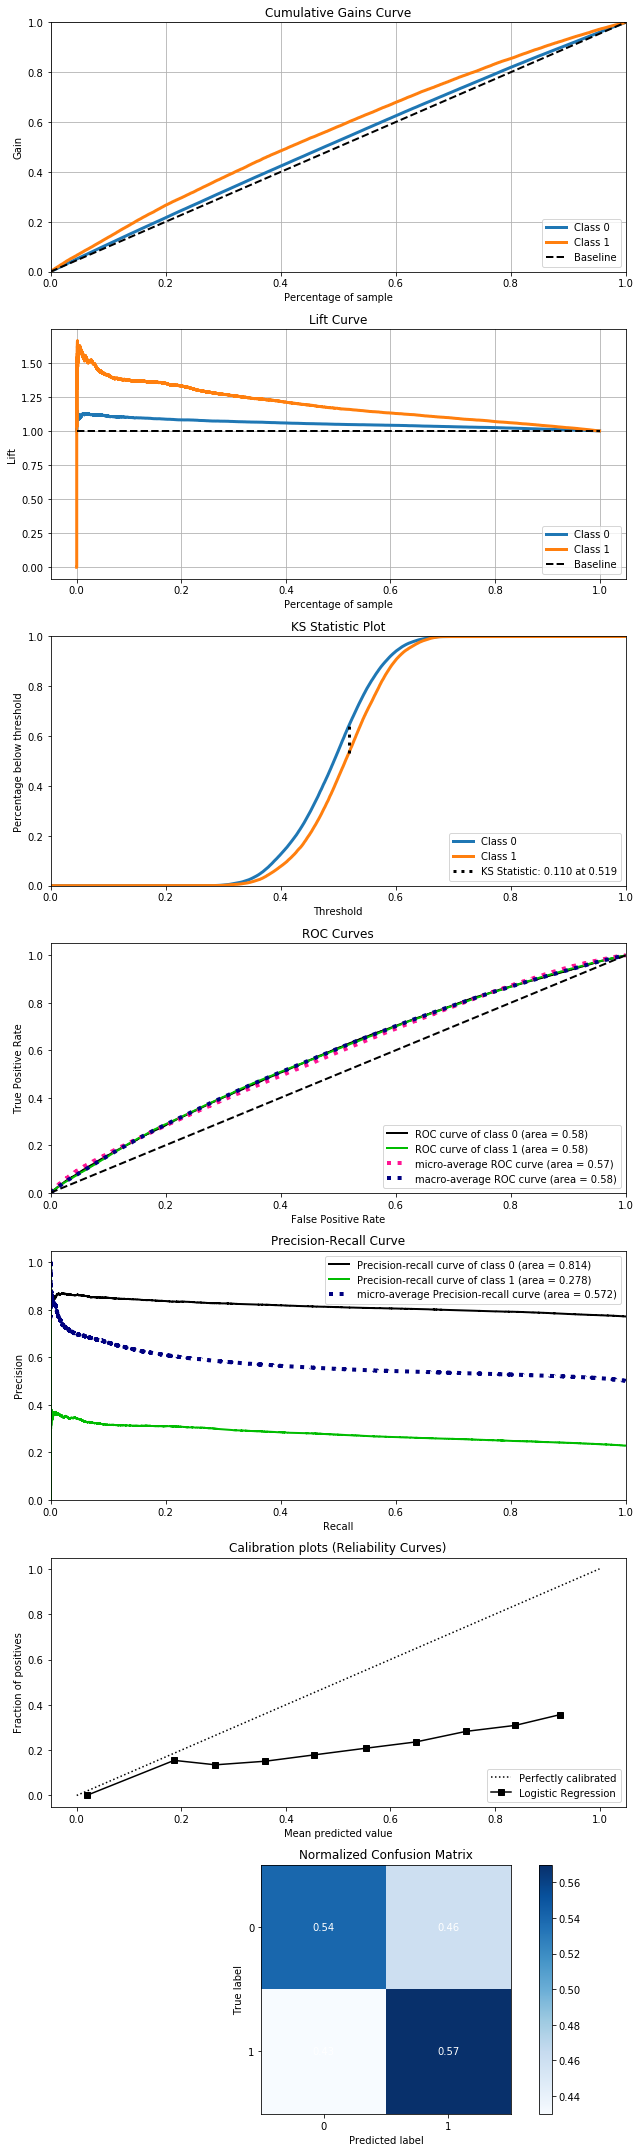

In [25]:
#plot metrics of oversampled lr model
print('Test Set Results with Oversampled Logistic Regression Model')
logreg_metrics_plots(lr_smote, Xtr_smote, ytr_smote, X_test, y_test, yts_smote_pred, yts_smote_prob)

#### Random Forest Classifier with Oversampled dataset

In [6]:
#create hyperparameter grid
rf_params = {'n_estimators': [100], 'max_features':[0.2, 'log2', 0.4]}

#Random Forest Classifier on  oversampled training data using GridSearchCV
GSCV_Rf_smote = GridSearchCV(RandomForestClassifier(), rf_params, n_jobs=2, cv=3).fit(Xtr_smote, ytr_smote)

In [7]:
#get best Random forest estimator from GSCV 
best_Rf_smote = GSCV_Rf_smote.best_estimator_

#Show results of RandomForest GSCV on oversampled dataset
print("Tuned Model Parameters: {}".format(GSCV_Rf_smote.best_params_))
print("Best GSCV score on Training Set: {:0.4f}".format(GSCV_Rf_smote.best_score_))

Tuned Model Parameters: {'max_features': 'log2', 'n_estimators': 100}
Best GSCV score on Training Set: 0.8963


In [8]:
#store Random Forest Classifier trained on Oversampled Data
joblib.dump(best_Rf_smote, 'CP1_binary_RandomForestClassifier_smote.pkl')

['CP1_binary_RandomForestClassifier_smote.pkl']

In [9]:
#load Random Forest Classifier trained on Oversampled Data
best_Rf_smote = joblib.load('CP1_binary_RandomForestClassifier_smote.pkl')

In [10]:
#get predicted values for best RandomForest estimator on oversampled dataset
ytr_smote_pred, yts_smote_pred, yts_smote_prob = get_pred_prob(best_Rf_smote, Xtr_smote, X_test)

#get classification metrics for best RandomForest GSCV estimator
print('Classification Metrics for Oversampled Random Forest Classifier')
classification_metrics(best_Rf_smote, Xtr_smote, ytr_smote, ytr_smote_pred, X_test, y_test, yts_smote_pred)

Classification Metrics for Oversampled Random Forest Classifier
----------------------------------------------------
CV-Accuracy on training data: 0.9032 (+/- 0.1080)
CV-Accuracy on test data: 0.8092 (+/- 0.0019)
----------------------------------------------------
[Training Classification Report]
             precision    recall  f1-score   support

          0       0.96      0.95      0.95    477153
          1       0.95      0.96      0.95    477153

avg / total       0.95      0.95      0.95    954306

----------------------------------------------------
[Test Classification Report]
             precision    recall  f1-score   support

          0       0.89      0.91      0.90    204495
          1       0.67      0.60      0.64     60350

avg / total       0.84      0.84      0.84    264845

----------------------------------------------------


Test Set Results with Oversampled Random Forest Classifier


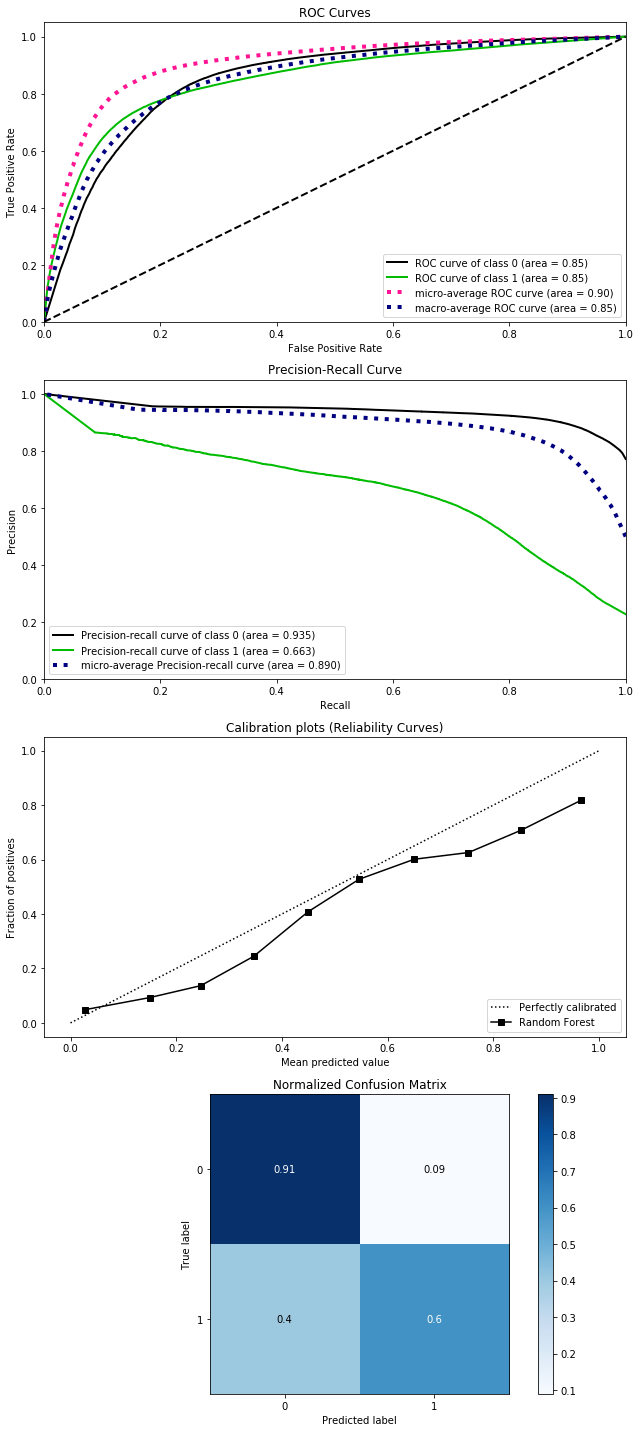

In [11]:
#plot metrics of oversampled randomforest classifier
print('Test Set Results with Oversampled Random Forest Classifier')
randforest_metrics_plots(best_Rf_smote, Xtr_smote, ytr_smote, X_test, y_test, yts_smote_pred, yts_smote_prob)

##### Final Results:
- Utilizing the AUC score as the primary comparative statistic for model performance, the RandomForest Classifier trained on data oversampled using SMOTE (Synthetic Minority Oversampling Technique) performed best, with an AUC of 0.85, a Precision score for the delay class of 0.67, and an F1-score of 0.64.

- The Random Forest Classifier trained on data using the Random Under Sampling technique had a higher Recall score for the delay class (0.77), but considerably lower Precision, with a score of 0.49. Meaning it had a lower false positive rate, but of the additional results being returned, most had incorrect labels in comparison to the training labels. 

- Overall, of the two four estimators trained, the logistic regression models performed the worst, proving unreliable for this particular problem, although they might potentially be improved if weights were added to the classes. Therefore, the ensemble approach appears to more approriate for this problem moving forward, and of the two Random Forest Classifiers, the one trained on the SMOTE training set yielded the most useful results, and would be my recommendation to a potential client.